# 01 - Classificação com Validação Cruzada Estratificada

Este notebook realiza o pré-processamento, separação de atributos/rótulos e avaliação de três algoritmos supervisionados:
- Árvore de Decisão (Random Forest)
- K-NN (K-Nearest Neighbors)
- MLP (Multi-Layer Perceptron)

A avaliação utiliza F1-score e matriz de confusão via validação cruzada estratificada k-fold, com `random_state` fixo para reprodutibilidade.


In [1]:
# Configurações gerais
RANDOM_STATE = 42
N_JOBS = -1
N_SPLITS = 5  # k-fold
TEST_SIZE = 0.2

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_val_score,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (
    f1_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    make_scorer,
    classification_report,
    accuracy_score,
    log_loss
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
import warnings
from sklearn.model_selection import cross_val_predict



In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# Carregamento de dados


## Pré-processamento

### Montando o dataframe

- Carrega um arquivo JSON contendo frames de vídeo com keypoints (pontos-chave) de movimentos
- Normaliza as coordenadas usando o keypoint 0 do primeiro frame como referência
- Filtra apenas os keypoints de ID 11 a 22 (Deixa somente membros superiores, braços, mãos etc.)
    - A visibilidade a partir do keypoint 25 (dos Joelhos para baixo) é muito baixa e também não é tão importante na língua de sinais.
- Calcula estatísticas (média, desvio padrão, mínimo, máximo) para cada keypoint
- Retorna um dicionário com todas as métricas calculadas para cada keypoint
- Não considera o eixo z, pois não se provou muito efetivo em testes

In [4]:
sinais = pd.read_csv('../data/Sinais/sinais.csv')
print(sinais.shape)
print(sinais.head())

def extrair_metricas_do_arquivo(caminho_arquivo):
    """
    Extrai métricas estatísticas dos keypoints de um arquivo JSON de movimentos.
    
    Esta função processa um arquivo JSON contendo frames de vídeo com keypoints,
    normaliza as coordenadas usando o keypoint 0 do primeiro frame como referência,
    filtra apenas os keypoints de ID 11 a 22 (membros superiores) e calcula
    estatísticas para cada keypoint.
    
    Args:
        caminho_arquivo (str): Caminho para o arquivo JSON a ser processado
        
    Returns:
        dict: Dicionário contendo todas as métricas calculadas para cada keypoint
              (média, desvio padrão, mínimo e máximo para x, y e visibilidade)
              
    Raises:
        ValueError: Se o frame 0 não contiver o keypoint com ID 0
    """
    # Carregando o arquivo JSON
    sinal = pd.read_json(caminho_arquivo)
    frames = sinal['frames']
    dados_keypoints = []

    # --- Normalização: pega keypoint id=0 do frame 0 como referência ---
    ref_x, ref_y = None, None
    for keypoint in frames[0]['keypoints']:
        if keypoint['id'] == 0:
            ref_x, ref_y = keypoint['x'], keypoint['y']
            break

    if ref_x is None:
        raise ValueError("Frame 0 não contém keypoint id=0!")

    # Iterando por todos os frames
    for frame_idx, frame_data in enumerate(frames):
        for keypoint in frame_data['keypoints']:
            if 11 <= keypoint['id'] <= 22:
                dados_keypoints.append({
                    'frame': frame_idx,
                    'id': keypoint['id'],
                    # Centralização: subtrai o ponto de referência (nariz)
                    'x': keypoint['x'] - ref_x,
                    'y': keypoint['y'] - ref_y,
                    'visibility': keypoint['visibility']
                })

    # Convertendo para DataFrame
    df_keypoints = pd.DataFrame(dados_keypoints)

    # Calculando métricas para cada ID e cada atributo
    metricas = df_keypoints.groupby('id').agg({
        'x': ['mean', 'std', 'min', 'max'],
        'y': ['mean', 'std', 'min', 'max'],
        'visibility': ['mean', 'std', 'min', 'max']
    })

    # Achatando colunas
    metricas.columns = ['_'.join(col).strip() for col in metricas.columns.values]
    metricas = metricas.reset_index()

    # Criando dicionário com todas as métricas
    metricas_dict = {}
    for _, row in metricas.iterrows():
        id_keypoint = int(row['id'])
        for col in metricas.columns:
            if col != 'id':
                metricas_dict[f'id_{id_keypoint}_{col}'] = row[col]

    return metricas_dict

(2502, 7)
           file_name  width  height  duration_sec  num_frames   sinal interprete
0  Adição_AP_10.json    738    1008      4.533333         136  Adição    Alexson
1   Adição_AP_1.json    774    1006      4.766667         143  Adição    Alexson
2   Adição_AP_2.json    760    1002      4.433333         133  Adição    Alexson
3   Adição_AP_3.json    762    1000      4.933333         148  Adição    Alexson
4   Adição_AP_4.json    764    1004      4.600000         138  Adição    Alexson


In [5]:
def aplicar_data_augmentation(metricas_dict, num_variantes=3, variacao_percentual=0.05):
    """
    Aplica data augmentation gerando variantes com pequenas perturbações apenas nas coordenadas x e y.
    
    Args:
        metricas_dict: Dicionário com as métricas originais
        num_variantes: Número de variantes a serem geradas
        variacao_percentual: Percentual máximo de variação a ser aplicado
        
    Returns:
        Lista de dicionários com as métricas originais e suas variantes
    """
    resultados = [metricas_dict.copy()]  # Inclui o original
    
    for i in range(num_variantes):
        variante = {}
        for chave, valor in metricas_dict.items():
            # Aplicar variação apenas em valores de x e y
            if isinstance(valor, (int, float)) and ('_x_' in chave or '_y_' in chave):
                # Calcula a variação máxima permitida
                variacao_max = abs(valor * variacao_percentual)
                # Gera um valor aleatório dentro do intervalo de variação
                perturbacao = np.random.uniform(-variacao_max, variacao_max)
                variante[chave] = valor + perturbacao
            else:
                variante[chave] = valor
        
        resultados.append(variante)
    
    return resultados

In [6]:
# --- Pipeline de extração de todos os arquivos ---
resultados = pd.DataFrame()

for idx, row in sinais.iterrows():
    caminho_arquivo = f'../data/Sinais/Sinais/{row["file_name"]}'
    try:
        metricas_arquivo = extrair_metricas_do_arquivo(caminho_arquivo)
        
        # Aplica data augmentation
        metricas_aumentadas = aplicar_data_augmentation(metricas_arquivo, num_variantes=3)
        
        for metricas in metricas_aumentadas:
            temp_df = pd.DataFrame([{**row, **metricas}])
            resultados = pd.concat([resultados, temp_df], ignore_index=True)

        if idx % 500 == 0:
            print(f"Processados {idx+1} arquivos de {len(sinais)}")

    except Exception as e:
        print(f"Erro ao processar {row['file_name']}: {e}")

Processados 1 arquivos de 2502
Erro ao processar Adição_MA_1.json: Frame 0 não contém keypoint id=0!
Processados 501 arquivos de 2502


/var/folders/ns/qqkzf_x52rqdpshm0vpl205r0000gn/T/ipykernel_87756/4267460456.py:25: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sinal = pd.read_json(caminho_arquivo)


Erro ao processar nan: Expected object or value
Processados 1001 arquivos de 2502
Processados 1501 arquivos de 2502
Processados 2001 arquivos de 2502
Processados 2501 arquivos de 2502


In [7]:
resultados.head()


,file_name,width,height,duration_sec,num_frames,sinal,interprete,id_11_x_mean,id_11_x_std,id_11_x_min,id_11_x_max,id_11_y_mean,id_11_y_std,id_11_y_min,id_11_y_max,id_11_visibility_mean,id_11_visibility_std,id_11_visibility_min,id_11_visibility_max,id_12_x_mean,id_12_x_std,id_12_x_min,id_12_x_max,id_12_y_mean,id_12_y_std,id_12_y_min,id_12_y_max,id_12_visibility_mean,id_12_visibility_std,id_12_visibility_min,id_12_visibility_max,id_13_x_mean,id_13_x_std,id_13_x_min,id_13_x_max,id_13_y_mean,id_13_y_std,id_13_y_min,id_13_y_max,id_13_visibility_mean,id_13_visibility_std,id_13_visibility_min,id_13_visibility_max,id_14_x_mean,id_14_x_std,id_14_x_min,id_14_x_max,id_14_y_mean,id_14_y_std,id_14_y_min,id_14_y_max,id_14_visibility_mean,id_14_visibility_std,id_14_visibility_min,id_14_visibility_max,id_15_x_mean,id_15_x_std,id_15_x_min,id_15_x_max,id_15_y_mean,id_15_y_std,id_15_y_min,id_15_y_max,id_15_visibility_mean,id_15_visibility_std,id_15_visibility_min,id_15_visibility_max,id_16_x_mean,id_16_x_std,id_16_x_min,id_16_x_max,id_16_y_mean,id_16_y_std,id_16_y_min,id_16_y_max,id_16_visibility_mean,id_16_visibility_std,id_16_visibility_min,id_16_visibility_max,id_17_x_mean,id_17_x_std,id_17_x_min,id_17_x_max,id_17_y_mean,id_17_y_std,id_17_y_min,id_17_y_max,id_17_visibility_mean,id_17_visibility_std,id_17_visibility_min,id_17_visibility_max,id_18_x_mean,id_18_x_std,id_18_x_min,id_18_x_max,id_18_y_mean,id_18_y_std,id_18_y_min,id_18_y_max,id_18_visibility_mean,id_18_visibility_std,id_18_visibility_min,id_18_visibility_max,id_19_x_mean,id_19_x_std,id_19_x_min,id_19_x_max,id_19_y_mean,id_19_y_std,id_19_y_min,id_19_y_max,id_19_visibility_mean,id_19_visibility_std,id_19_visibility_min,id_19_visibility_max,id_20_x_mean,id_20_x_std,id_20_x_min,id_20_x_max,id_20_y_mean,id_20_y_std,id_20_y_min,id_20_y_max,id_20_visibility_mean,id_20_visibility_std,id_20_visibility_min,id_20_visibility_max,id_21_x_mean,id_21_x_std,id_21_x_min,id_21_x_max,id_21_y_mean,id_21_y_std,id_21_y_min,id_21_y_max,id_21_visibility_mean,id_21_visibility_std,id_21_visibility_min,id_21_visibility_max,id_22_x_mean,id_22_x_std,id_22_x_min,id_22_x_max,id_22_y_mean,id_22_y_std,id_22_y_min,id_22_y_max,id_22_visibility_mean,id_22_visibility_std,id_22_visibility_min,id_22_visibility_max
0,Adição_AP_10.json,738,1008,4.533333,136,Adição,Alexson,183.845588,2.511835,180.000000,190.000000,198.169118,4.561603,189.000000,203.000000,1.0,0.0,1.0,1.0,-156.220588,5.778237,-163.000000,-138.000000,192.198529,5.374590,180.000000,199.000000,1.0,0.0,1.0,1.0,239.051471,20.950142,199.000000,261.000000,460.316176,5.452423,454.000000,472.000000,1.000000,0.000000,1.00,1.0,-271.669118,65.398387,-369.000000,-213.000000,406.279412,63.158905,298.000000,461.000000,1.0,0.0,1.0,1.0,64.242647,37.984109,7.000000,98.000000,505.735294,137.498134,272.000000,619.000000,0.986985,0.009453,0.97,1.0,-116.463235,64.089163,-226.000000,-57.000000,454.566176,188.854547,165.000000,624.000000,0.982868,0.011149,0.97,1.0,16.102941,41.610234,-48.000000,53.000000,539.911765,187.441664,224.000000,689.000000,0.964191,0.021101,0.90,0.99,-66.514706,58.612347,-169.000000,-11.000000,491.823529,227.956100,140.000000,692.000000,0.951029,0.017139,0.92,0.98,4.889706,32.517727,-48.000000,37.000000,508.985294,186.493252,197.000000,658.000000,0.966397,0.019039,0.91,0.99,-39.477941,58.173937,-139.000000,16.000000,465.352941,215.872168,133.000000,656.000000,0.953529,0.014065,0.93,0.98,16.073529,31.556799,-34.000000,46.000000,492.933824,168.908838,211.000000,631.000000,0.965809,0.018720,0.91,0.99,-47.250000,57.658991,-146.000000,9.000000,456.227941,201.162583,149.000000,635.000000,0.950882,0.016621,0.92,0.98
1,Adição_AP_10.json,738,1008,4.533333,136,Adição,Alexson,187.617257,2.478506,176.055637,195.369393,195.630893,4.391129,197.222320,200.864896,1.0,0.0,1.0,1.0,-161.495316,5.670961,-171.110322,-138.920230,189.413362,5.345486,187.865815,207.518487,1.0,0.0,1.0,1.0,232.828912,21.300709,206.062645,261.397920,438.149935,5.247562,448.092993,459.240877,1.000000

In [8]:
resultados.shape

(10000, 151)

# EDA

Análise Exploratória dos Dados (EDA)

- Verificação das dimensões do dataset (10.000 linhas, 151 colunas)
- Análise dos tipos de dados em cada coluna
- Verificação de valores nulos no conjunto de dados
- Cálculo de estatísticas descritivas para colunas numéricas
- Análise da distribuição dos sinais (classes) - balanceamento entre as 25 classes
- Análise da distribuição dos intérpretes - 10 intérpretes com distribuição equilibrada
- Identificação de outliers usando o método IQR (Intervalo Interquartil)
- Preparação dos dados para classificação com codificação das classes

In [9]:
# Análise Exploratória dos Dados

# Verificando as dimensões do dataset
print(f"Dimensões do dataset: {resultados.shape}")

# Verificando os tipos de dados
print("\nTipos de dados:")
print(resultados.dtypes)

# Verificando valores nulos
print("\nValores nulos por coluna:")
print(resultados.isnull().sum())

# Estatísticas descritivas para colunas numéricas
print("\nEstatísticas descritivas para colunas numéricas:")
print(resultados.describe())

# Verificando a distribuição dos sinais (classes)
print("\nDistribuição dos sinais (classes):")
print(resultados['sinal'].value_counts())

# Verificando a distribuição dos intérpretes
print("\nDistribuição dos intérpretes:")
print(resultados['interprete'].value_counts())

# Identificando possíveis outliers em colunas numéricas
print("\nIdentificando outliers em algumas colunas numéricas:")
colunas_numericas = resultados.select_dtypes(include=['int64', 'float64']).columns 

for coluna in colunas_numericas:
    Q1 = resultados[coluna].quantile(0.25)
    Q3 = resultados[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = resultados[(resultados[coluna] < limite_inferior) | (resultados[coluna] > limite_superior)]
    print(f"\nOutliers na coluna {coluna}: {len(outliers)} ({len(outliers)/len(resultados)*100:.2f}%)")

# Criando uma cópia do dataframe para trabalhar com a classificação
df = resultados.copy()

# Criando uma coluna target numérica a partir da coluna 'sinal'
le = LabelEncoder()
df['target'] = le.fit_transform(df['sinal'])

# Mapeamento das classes
print("\nMapeamento das classes (sinal -> target):")
for i, classe in enumerate(le.classes_):
    print(f"{classe} -> {i}")


Dimensões do dataset: (10000, 151)

Tipos de dados:
file_name                 object
width                      int64
height                     int64
duration_sec             float64
num_frames                 int64
                          ...   
id_22_y_max              float64
id_22_visibility_mean    float64
id_22_visibility_std     float64
id_22_visibility_min     float64
id_22_visibility_max     float64
Length: 151, dtype: object

Valores nulos por coluna:
file_name                0
width                    0
height                   0
duration_sec             0
num_frames               0
                        ..
id_22_y_max              0
id_22_visibility_mean    0
id_22_visibility_std     0
id_22_visibility_min     0
id_22_visibility_max     0
Length: 151, dtype: int64

Estatísticas descritivas para colunas numéricas:
              width        height  duration_sec    num_frames  id_11_x_mean   id_11_x_std   id_11_x_min   id_11_x_max  \
count  10000.000000  10000.000000  10

Dimensões do dataset: (10000, 151)

Tipos de dados (contagem):
float64    145
object       3
int64        3
Name: count, dtype: int64


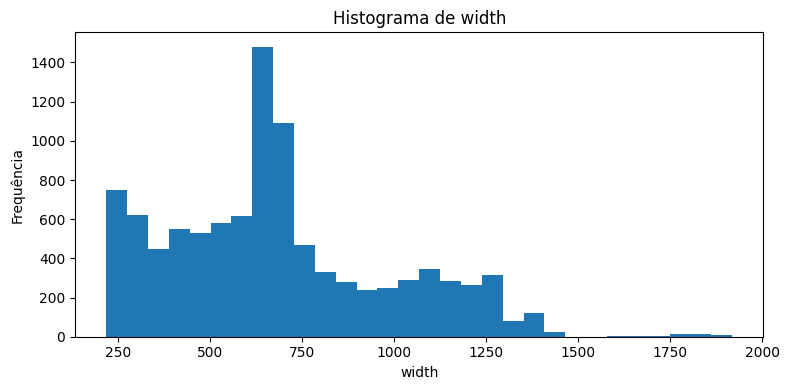

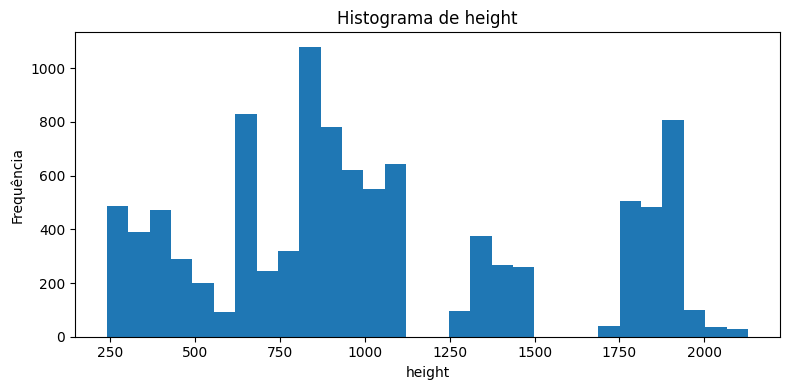

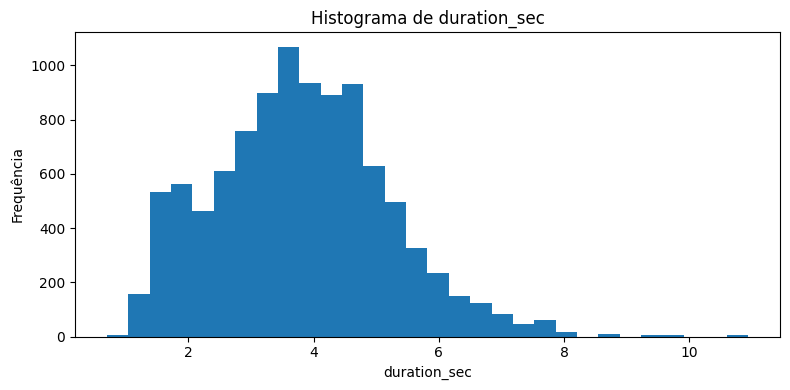

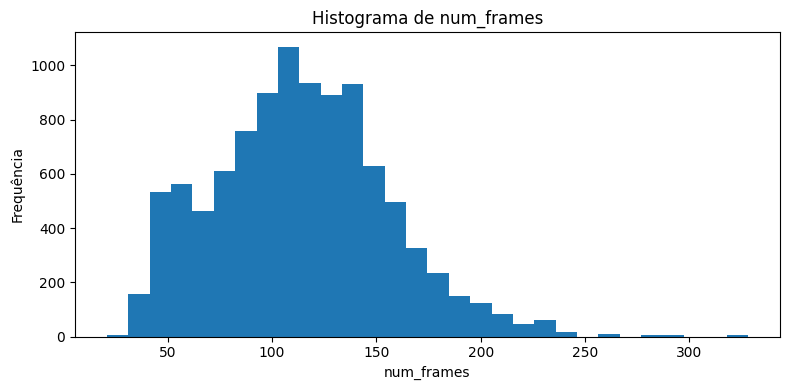

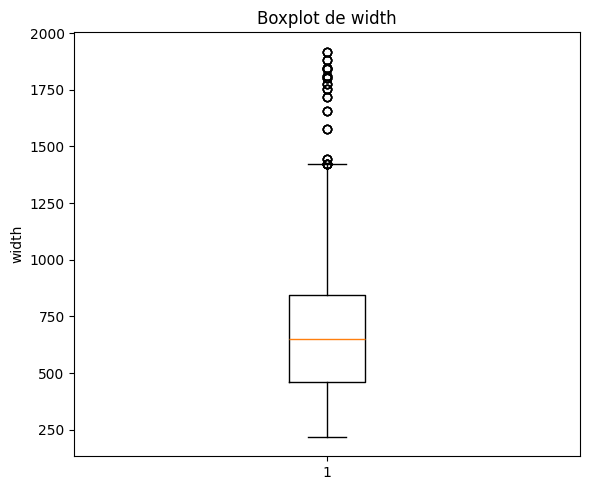

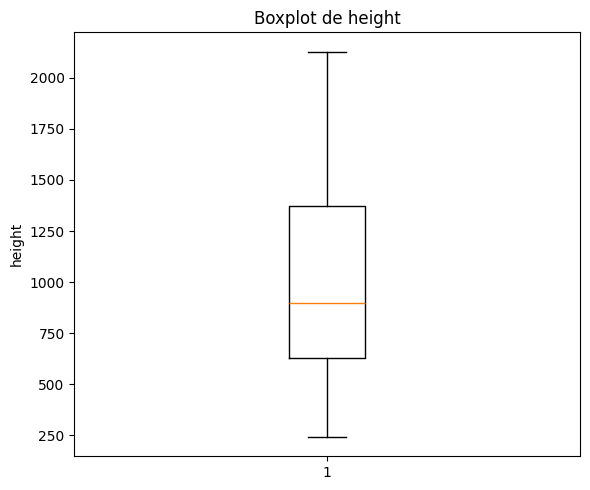

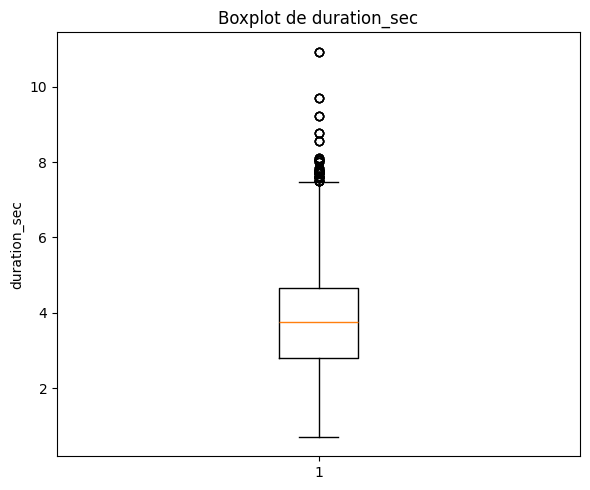

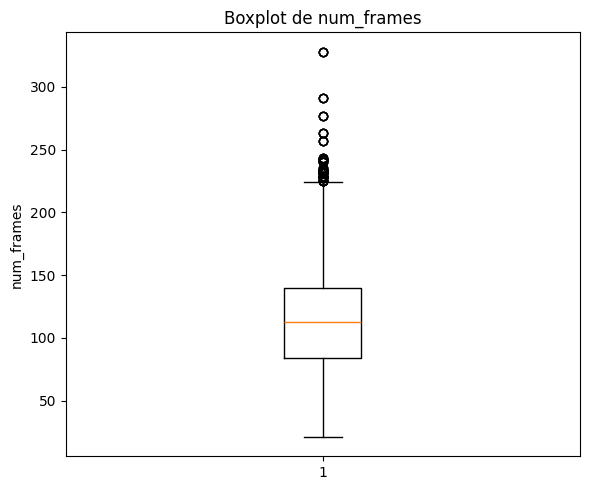

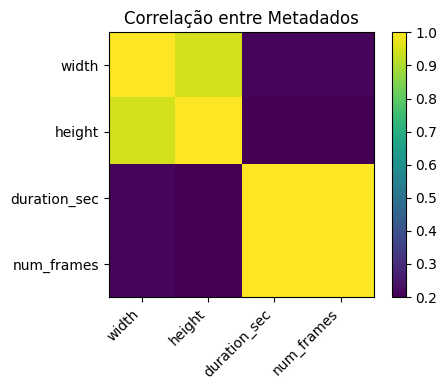

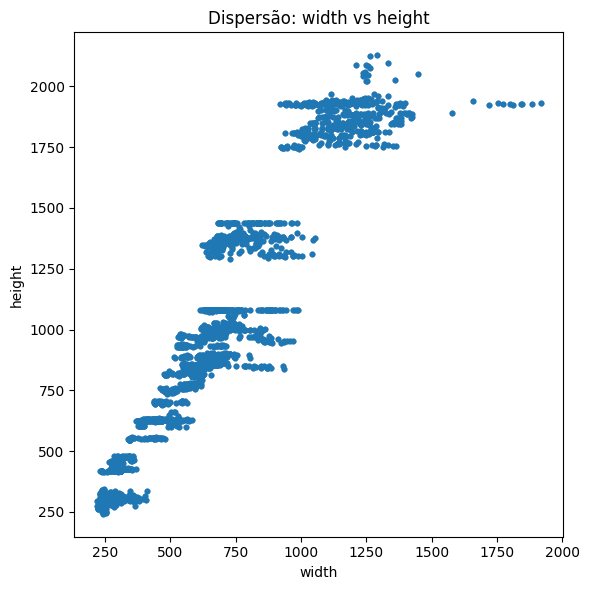

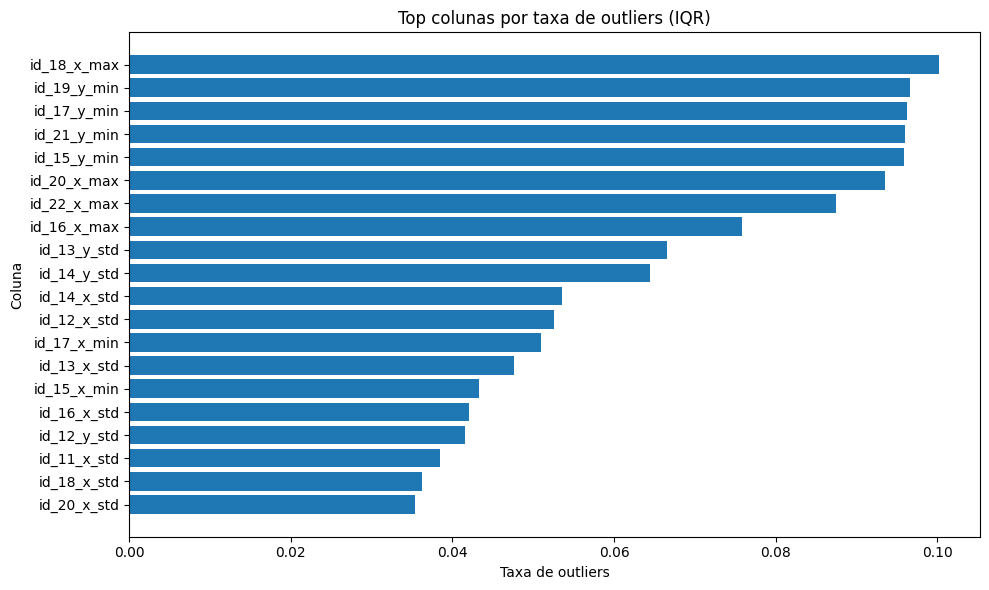


Top colunas por taxa de outliers (IQR):


,coluna,taxa_outlier
63,id_18_x_max,0.1003
74,id_19_y_min,0.0967
58,id_17_y_min,0.0963
90,id_21_y_min,0.0960
42,id_15_y_min,0.0959
79,id_20_x_max,0.0935
95,id_22_x_max,0.0875
47,id_16_x_max,0.0759
25,id_13_y_std,0.0666
33,id_14_y_std,0.0644



Estatísticas descritivas (numéricas):


,count,mean,std,min,25%,50%,75%,max
width,10000.0,683.740000,303.017569,218.000000,461.500000,650.000000,846.000000,1918.000000
height,10000.0,1027.487200,508.098428,242.000000,628.000000,898.000000,1374.500000,2128.000000
duration_sec,10000.0,3.797213,1.379031,0.700000,2.800000,3.766667,4.666667,10.933333
num_frames,10000.0,113.916400,41.370934,21.000000,84.000000,113.000000,140.000000,328.000000
id_11_x_mean,10000.0,158.614918,69.458612,38.115861,98.384711,156.681782,184.372140,314.451444
...,...,...,...,...,...,...,...,...
id_22_x_max,10000.0,-17.286248,94.154796,-382.061081,-60.199416,-7.960718,26.800243,281.678314
id_22_y_mean,10000.0,496.612092,282.470594,44.257839,269.374945,454.641988,641.551872,1213.366321
id_22_y_std,10000.0,222.524647,147.429495,0.702197,118.973955,193.919444,300.484245,700.422112
id_22_y_min,10000.0,168.040295,138.394438,-284.860213,72.245153,144.471089,248.000000,614.660247



Contagem por classe (sinal):


,sinal,contagem
0,Aluno,404
1,Adição,400
2,Contexto,400
3,História,400
4,Geografia,400
5,Física,400
6,Filosofia,400
7,Estudar,400
8,Escola,400
9,Ensinar,400



Contagem por intérprete:


,interprete,contagem
0,Alexson,1004
1,Cecilia,1000
2,Dannubia,1000
3,Dilainne,1000
4,Everton,1000
5,Jackeline,1000
6,Luana,1000
7,Rosenice,1000
8,Tiago,1000
9,Aparecida,996


In [10]:
def explorar_resultados(df: pd.DataFrame, *, topk_outliers: int = 20):
    assert isinstance(df, pd.DataFrame), "`df` precisa ser um DataFrame"
    assert {'sinal','interprete'}.issubset(df.columns), "faltam colunas 'sinal' e/ou 'interprete'"

    # --- 0) Info rápida ---
    print(f"Dimensões do dataset: {df.shape}")
    print("\nTipos de dados (contagem):")
    print(df.dtypes.value_counts())


    # Metadados mais usados (se existirem)
    meta_cols = [c for c in ['width','height','duration_sec','num_frames'] if c in df.columns]

    # --- 3) Histogramas dos metadados ---
    for col in meta_cols:
        fig = plt.figure(figsize=(8, 4))
        plt.hist(df[col].dropna(), bins=30)
        plt.title(f"Histograma de {col}")
        plt.xlabel(col); plt.ylabel("Frequência")
        plt.tight_layout(); plt.show()

    # --- 4) Boxplots (inspeção de outliers) ---
    for col in meta_cols:
        fig = plt.figure(figsize=(6, 5))
        plt.boxplot(df[col].dropna(), vert=True, showfliers=True)
        plt.title(f"Boxplot de {col}")
        plt.ylabel(col)
        plt.tight_layout(); plt.show()

    # --- 5) Correlação entre metadados ---
    if len(meta_cols) >= 2:
        corr = df[meta_cols].corr()
        fig = plt.figure(figsize=(5, 4))
        plt.imshow(corr, interpolation='nearest')
        plt.xticks(range(len(meta_cols)), meta_cols, rotation=45, ha='right')
        plt.yticks(range(len(meta_cols)), meta_cols)
        plt.title("Correlação entre Metadados")
        plt.colorbar()
        plt.tight_layout(); plt.show()

    # --- 6) Dispersão width vs height (se existirem) ---
    if all(c in df.columns for c in ['width','height']):
        fig = plt.figure(figsize=(6, 6))
        plt.scatter(df['width'], df['height'], s=10, alpha=0.6)
        plt.title("Dispersão: width vs height")
        plt.xlabel("width"); plt.ylabel("height")
        plt.tight_layout(); plt.show()

    # --- 7) Top colunas por taxa de OUTLIERS (IQR) ---
    num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    # Excluindo colunas de visibilidade
    num_cols = [col for col in num_cols if 'visibility' not in col]
    
    def iqr_outlier_rate(s: pd.Series):
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        return float(((s < low) | (s > high)).mean())

    rates = []
    for c in num_cols:
        vals = df[c].dropna()
        if len(vals) > 0:
            rates.append((c, iqr_outlier_rate(vals)))

    if rates:
        out_df = (pd.DataFrame(rates, columns=['coluna','taxa_outlier'])
                    .sort_values('taxa_outlier', ascending=False))
        k = min(topk_outliers, len(out_df))
        fig = plt.figure(figsize=(10, 6))
        plt.barh(out_df['coluna'].head(k)[::-1], out_df['taxa_outlier'].head(k)[::-1])
        plt.title("Top colunas por taxa de outliers (IQR)")
        plt.xlabel("Taxa de outliers"); plt.ylabel("Coluna")
        plt.tight_layout(); plt.show()

        # tabela resumida
        print("\nTop colunas por taxa de outliers (IQR):")
        display(out_df.head(k))

    # --- 8) Tabelas úteis ---
    print("\nEstatísticas descritivas (numéricas):")
    display(df[num_cols].describe().T)

    print("\nContagem por classe (sinal):")
    display(df['sinal'].value_counts().rename_axis('sinal').reset_index(name='contagem'))

    print("\nContagem por intérprete:")
    display(df['interprete'].value_counts().rename_axis('interprete').reset_index(name='contagem'))

explorar_resultados(resultados)


# Retirando elementos com baixa visibilidade

In [11]:
# Definindo um limiar para considerar a visibilidade como baixa
limiar_visibilidade = 0.5

# Criando uma lista para armazenar as linhas com visibilidade baixa
linhas_visibilidade_baixa = []

# Identificando todas as colunas relacionadas à visibilidade
colunas_visibilidade = [col for col in resultados.columns if 'visibility' in col]

# Iterando sobre cada linha do DataFrame
for idx, row in resultados.iterrows():
    # Verificando se alguma coluna de visibilidade média está abaixo do limiar
    colunas_visibilidade_media = [col for col in colunas_visibilidade if 'visibility_mean' in col]
    
    # Se alguma coluna de visibilidade média estiver abaixo do limiar, adiciona à lista
    if any(row[col] < limiar_visibilidade for col in colunas_visibilidade_media):
        linhas_visibilidade_baixa.append(idx)

# Exibindo as linhas com visibilidade baixa
print(f"Foram encontradas {len(linhas_visibilidade_baixa)} linhas com visibilidade média abaixo de {limiar_visibilidade}")

# Selecionando apenas as colunas de visibilidade e informações básicas
colunas_para_exibir = ['file_name', 'sinal', 'interprete'] + colunas_visibilidade

# Exibindo todas as linhas com visibilidade baixa, mas apenas as colunas relacionadas à visibilidade
print("\nLinhas com visibilidade baixa (apenas colunas de visibilidade):")

# Verificando quais sinais têm mais problemas de visibilidade
sinais_problematicos = resultados.iloc[linhas_visibilidade_baixa]['sinal'].value_counts()

# Removendo as linhas com visibilidade baixa do DataFrame
resultados = resultados.drop(linhas_visibilidade_baixa)
print(f"\nDataFrame após remover linhas com visibilidade baixa: {resultados.shape}")

Foram encontradas 40 linhas com visibilidade média abaixo de 0.5

Linhas com visibilidade baixa (apenas colunas de visibilidade):

DataFrame após remover linhas com visibilidade baixa: (9960, 151)


# Retirando dados com baixa qualidade (largura ou altura < 300)

In [12]:
# Definindo limiares para considerar largura e altura como muito baixos
limiar_largura = 300  # Ajuste conforme necessário
limiar_altura = 300   # Ajuste conforme necessário

# Criando uma lista para armazenar as linhas com dimensões muito baixas
linhas_dimensoes_baixas = []

# Iterando sobre cada linha do DataFrame
for idx, row in resultados.iterrows():
    # Verificando se a largura ou altura está abaixo do limiar
    if row['width'] < limiar_largura or row['height'] < limiar_altura:
        linhas_dimensoes_baixas.append(idx)

# Exibindo informações sobre as linhas com dimensões baixas
print(f"Foram encontradas {len(linhas_dimensoes_baixas)} linhas com dimensões abaixo dos limiares (largura < {limiar_largura} ou altura < {limiar_altura})")

if len(linhas_dimensoes_baixas) > 0:
    # Exibindo detalhes das linhas com dimensões baixas
    print("\nDetalhes das linhas com dimensões baixas:")
    display(resultados.loc[linhas_dimensoes_baixas, ['file_name', 'width', 'height', 'sinal', 'interprete']])
    
    # Verificando quais sinais têm mais problemas de dimensões
    sinais_problematicos_dimensoes = resultados.iloc[linhas_dimensoes_baixas]['sinal'].value_counts()
    print("\nSinais com problemas de dimensões:")
    display(sinais_problematicos_dimensoes)
    
    # Removendo as linhas com dimensões baixas do DataFrame
    resultados = resultados.drop(linhas_dimensoes_baixas)
    print(f"\nDataFrame após remover linhas com dimensões baixas: {resultados.shape}")
else:
    print("Não foram encontradas linhas com dimensões abaixo dos limiares definidos.")


Foram encontradas 1176 linhas com dimensões abaixo dos limiares (largura < 300 ou altura < 300)

Detalhes das linhas com dimensões baixas:


,file_name,width,height,sinal,interprete
252,Bolsa_de_Estudos_AP_2.json,294,416,Bolsa de Estudos,Alexson
253,Bolsa_de_Estudos_AP_2.json,294,416,Bolsa de Estudos,Alexson
254,Bolsa_de_Estudos_AP_2.json,294,416,Bolsa de Estudos,Alexson
255,Bolsa_de_Estudos_AP_2.json,294,416,Bolsa de Estudos,Alexson
260,Bolsa_de_Estudos_AP_4.json,294,416,Bolsa de Estudos,Alexson
...,...,...,...,...,...
8943,História_RL_5.json,298,422,História,Rosenice
8956,História_RL_9.json,298,422,História,Rosenice
8957,História_RL_9.json,298,422,História,Rosenice
8958,História_RL_9.json,298,422,História,Rosenice



Sinais com problemas de dimensões:


sinal
Estudar             120
Geografia           108
História            104
Disciplina           88
Adição               80
Colega               80
Ensinar              76
Bolsa de Estudos     64
Ângulo               64
Curso                40
Escola               40
Dicionário           40
Apostila             40
Capítulo             40
Biologia             40
Apontador            40
Antropologia         40
Aluno                40
Coerência            20
Classe                8
Física                4
Name: count, dtype: int64


DataFrame após remover linhas com dimensões baixas: (8784, 151)


# Remoção de colunas

Vou remover as colunas que nao vão ajudar na classificação

In [13]:
# Identificando todas as colunas relacionadas à visibilidade
colunas_visibilidade = [col for col in resultados.columns if 'visibility' in col]

# Exibindo as colunas que serão removidas
print(f"Removendo {len(colunas_visibilidade)} colunas relacionadas à visibilidade:")
print(colunas_visibilidade)

# Removendo as colunas de visibilidade do DataFrame
resultados = resultados.drop(columns=colunas_visibilidade)
print(f"\nDimensões do DataFrame após remover colunas de visibilidade: {resultados.shape}")

# Removendo colunas que não são relevantes para a classificação
colunas_para_remover = ['file_name', 'duration_sec', 'num_frames', 'width', 'height']
resultados = resultados.drop(columns=colunas_para_remover)
print(f"Dimensões do DataFrame após remover colunas irrelevantes: {resultados.shape}")


Removendo 48 colunas relacionadas à visibilidade:
['id_11_visibility_mean', 'id_11_visibility_std', 'id_11_visibility_min', 'id_11_visibility_max', 'id_12_visibility_mean', 'id_12_visibility_std', 'id_12_visibility_min', 'id_12_visibility_max', 'id_13_visibility_mean', 'id_13_visibility_std', 'id_13_visibility_min', 'id_13_visibility_max', 'id_14_visibility_mean', 'id_14_visibility_std', 'id_14_visibility_min', 'id_14_visibility_max', 'id_15_visibility_mean', 'id_15_visibility_std', 'id_15_visibility_min', 'id_15_visibility_max', 'id_16_visibility_mean', 'id_16_visibility_std', 'id_16_visibility_min', 'id_16_visibility_max', 'id_17_visibility_mean', 'id_17_visibility_std', 'id_17_visibility_min', 'id_17_visibility_max', 'id_18_visibility_mean', 'id_18_visibility_std', 'id_18_visibility_min', 'id_18_visibility_max', 'id_19_visibility_mean', 'id_19_visibility_std', 'id_19_visibility_min', 'id_19_visibility_max', 'id_20_visibility_mean', 'id_20_visibility_std', 'id_20_visibility_min', 'id

In [14]:
resultados.head()

,sinal,interprete,id_11_x_mean,id_11_x_std,id_11_x_min,id_11_x_max,id_11_y_mean,id_11_y_std,id_11_y_min,id_11_y_max,id_12_x_mean,id_12_x_std,id_12_x_min,id_12_x_max,id_12_y_mean,id_12_y_std,id_12_y_min,id_12_y_max,id_13_x_mean,id_13_x_std,id_13_x_min,id_13_x_max,id_13_y_mean,id_13_y_std,id_13_y_min,id_13_y_max,id_14_x_mean,id_14_x_std,id_14_x_min,id_14_x_max,id_14_y_mean,id_14_y_std,id_14_y_min,id_14_y_max,id_15_x_mean,id_15_x_std,id_15_x_min,id_15_x_max,id_15_y_mean,id_15_y_std,id_15_y_min,id_15_y_max,id_16_x_mean,id_16_x_std,id_16_x_min,id_16_x_max,id_16_y_mean,id_16_y_std,id_16_y_min,id_16_y_max,id_17_x_mean,id_17_x_std,id_17_x_min,id_17_x_max,id_17_y_mean,id_17_y_std,id_17_y_min,id_17_y_max,id_18_x_mean,id_18_x_std,id_18_x_min,id_18_x_max,id_18_y_mean,id_18_y_std,id_18_y_min,id_18_y_max,id_19_x_mean,id_19_x_std,id_19_x_min,id_19_x_max,id_19_y_mean,id_19_y_std,id_19_y_min,id_19_y_max,id_20_x_mean,id_20_x_std,id_20_x_min,id_20_x_max,id_20_y_mean,id_20_y_std,id_20_y_min,id_20_y_max,id_21_x_mean,id_21_x_std,id_21_x_min,id_21_x_max,id_21_y_mean,id_21_y_std,id_21_y_min,id_21_y_max,id_22_x_mean,id_22_x_std,id_22_x_min,id_22_x_max,id_22_y_mean,id_22_y_std,id_22_y_min,id_22_y_max
0,Adição,Alexson,183.845588,2.511835,180.000000,190.000000,198.169118,4.561603,189.000000,203.000000,-156.220588,5.778237,-163.000000,-138.000000,192.198529,5.374590,180.000000,199.000000,239.051471,20.950142,199.000000,261.000000,460.316176,5.452423,454.000000,472.000000,-271.669118,65.398387,-369.000000,-213.000000,406.279412,63.158905,298.000000,461.000000,64.242647,37.984109,7.000000,98.000000,505.735294,137.498134,272.000000,619.000000,-116.463235,64.089163,-226.000000,-57.000000,454.566176,188.854547,165.000000,624.000000,16.102941,41.610234,-48.000000,53.000000,539.911765,187.441664,224.000000,689.000000,-66.514706,58.612347,-169.000000,-11.000000,491.823529,227.956100,140.000000,692.000000,4.889706,32.517727,-48.000000,37.000000,508.985294,186.493252,197.000000,658.000000,-39.477941,58.173937,-139.000000,16.000000,465.352941,215.872168,133.000000,656.000000,16.073529,31.556799,-34.000000,46.000000,492.933824,168.908838,211.000000,631.000000,-47.250000,57.658991,-146.000000,9.000000,456.227941,201.162583,149.000000,635.000000
1,Adição,Alexson,187.617257,2.478506,176.055637,195.369393,195.630893,4.391129,197.222320,200.864896,-161.495316,5.670961,-171.110322,-138.920230,189.413362,5.345486,187.865815,207.518487,232.828912,21.300709,206.062645,261.397920,438.149935,5.247562,448.092993,459.240877,-272.775390,62.665538,-360.117360,-202.971342,388.329220,63.690839,283.208539,468.730240,66.950554,39.372108,6.739437,94.560990,512.692352,139.933001,262.315820,600.521028,-116.083815,63.889502,-236.856530,-57.470396,435.534379,179.527610,167.580548,613.047342,15.819198,40.828792,-49.234258,53.541257,548.470669,193.848272,214.087408,662.203345,-64.705318,57.856318,-162.743732,-11.195696,487.644587,216.742440,144.311606,703.962913,4.719148,31.247660,-46.428942,36.040798,501.488299,190.900078,189.656107,684.143876,-40.350198,55.975060,-133.230986,15.922569,462.560460,213.794414,134.243566,679.573065,16.430100,31.040750,-35.078041,48.231783,484.999888,163.592902,210.942821,653.208876,-49.412430,60.153534,-140.459412,8.964343,444.965187,209.068077,154.872018,650.915253
2,Adição,Alexson,174.674166,2.390778,176.378550,184.414162,197.623059,4.392452,182.129241,210.419081,-152.943379,5.632559,-167.104503,-141.599821,194.028057,5.518895,176.932560,191.187085,247.253281,20.961371,203.480921,255.336977,464.943825,5.188998,465.539373,448.881743,-264.791778,63.646387,-352.288425,-216.737916,423.494217,60.345206,288.667250,467.532460,67.031758,39.278128,7.103819,100.537220,526.625177,139.973773,268.374205,630.929665,-119.206691,61.033304,-225.868257,-55.681922,441.934604,188.603277,171.216006,628.096194,16.675735,42.587820,-47.403320,52.684408,518.819045,183.955870,221.347748,715.285930,-69.280822,58.361333,-174.431381,-11.458715,477.242642,218.906523,138.591448,665.330568,

In [15]:
backup_resultados = resultados.copy()

In [16]:
resultados = backup_resultados.copy()

# Separar features e target


In [17]:

# Definindo coluna alvo
TARGET_COL = 'sinal'

# Codificando o target como inteiro e substituindo no DataFrame
label_encoder = LabelEncoder()
resultados[TARGET_COL] = label_encoder.fit_transform(resultados[TARGET_COL])

# Agora sinal já é inteiro no DataFrame
y = resultados[TARGET_COL].copy()

# Features (removendo target e interprete)
feature_cols = [c for c in resultados.columns if c not in [TARGET_COL, 'interprete']]
X = resultados[feature_cols].copy()


# Train e test sets

In [18]:
# Definindo intérpretes que vão para o conjunto de teste
test_interpretes = ['Dannubia', 'Cecilia']

# Criando máscara de teste/treino
mask_test = resultados['interprete'].isin(test_interpretes)

X_train = X[~mask_test].copy()
y_train = y[~mask_test].copy()

X_test = X[mask_test].copy()
y_test = y[mask_test].copy()

print(f"Conjunto de treino: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Conjunto de teste: X_test={X_test.shape}, y_test={y_test.shape}")

# Criando preprocessador para features numéricas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),  # Usando RobustScaler para normalização baseada em mediana e IQR
    ],
    remainder='drop'
)

# Distribuição das classes
print("\nDistribuição das classes nos conjuntos:")


Conjunto de treino: X_train=(6784, 96), y_train=(6784,)
Conjunto de teste: X_test=(2000, 96), y_test=(2000,)

Distribuição das classes nos conjuntos:


# Implementando Random Forest

### pipeline

In [19]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=40)),  # melhor PCA encontrado
    ("rf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        n_estimators=300,          # melhor número de árvores
        max_depth=20,              # melhor profundidade máxima
        min_samples_split=10       # melhor split mínimo
    ))
])

### Validacao Cruzada

In [20]:
groups = resultados['interprete'].values

# Definir StratifiedGroupKFold
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# F1-score macro
f1_macro = make_scorer(f1_score, average="macro")

# Validação cruzada estratificada com grupos (apenas no treino)
scores = cross_val_score(
    pipeline,
    X, y,
    cv=cv,
    scoring=f1_macro,
    groups=groups,
    n_jobs=-1
)

print("F1 por fold (grouped CV):", scores)
print("Média do F1-score na validação cruzada:", scores.mean())



F1 por fold (grouped CV): [0.63539241 0.32910336 0.66877366 0.26402521 0.33753513]
Média do F1-score na validação cruzada: 0.4469659520421973


### Test Set

In [21]:
# Treinar modelo final com todos os dados de treino
pipeline.fit(X_train, y_train)

# Avaliar no conjunto de teste ('Dannubia', 'Cecilia')
y_pred = pipeline.predict(X_test)
test_score = f1_score(y_test, y_pred, average="macro")
print(f"F1-score no conjunto de teste final (Dannubia e Cecilia): {test_score:.4f}")

F1-score no conjunto de teste final (Dannubia e Cecilia): 0.4627


### Matriz de Confusão

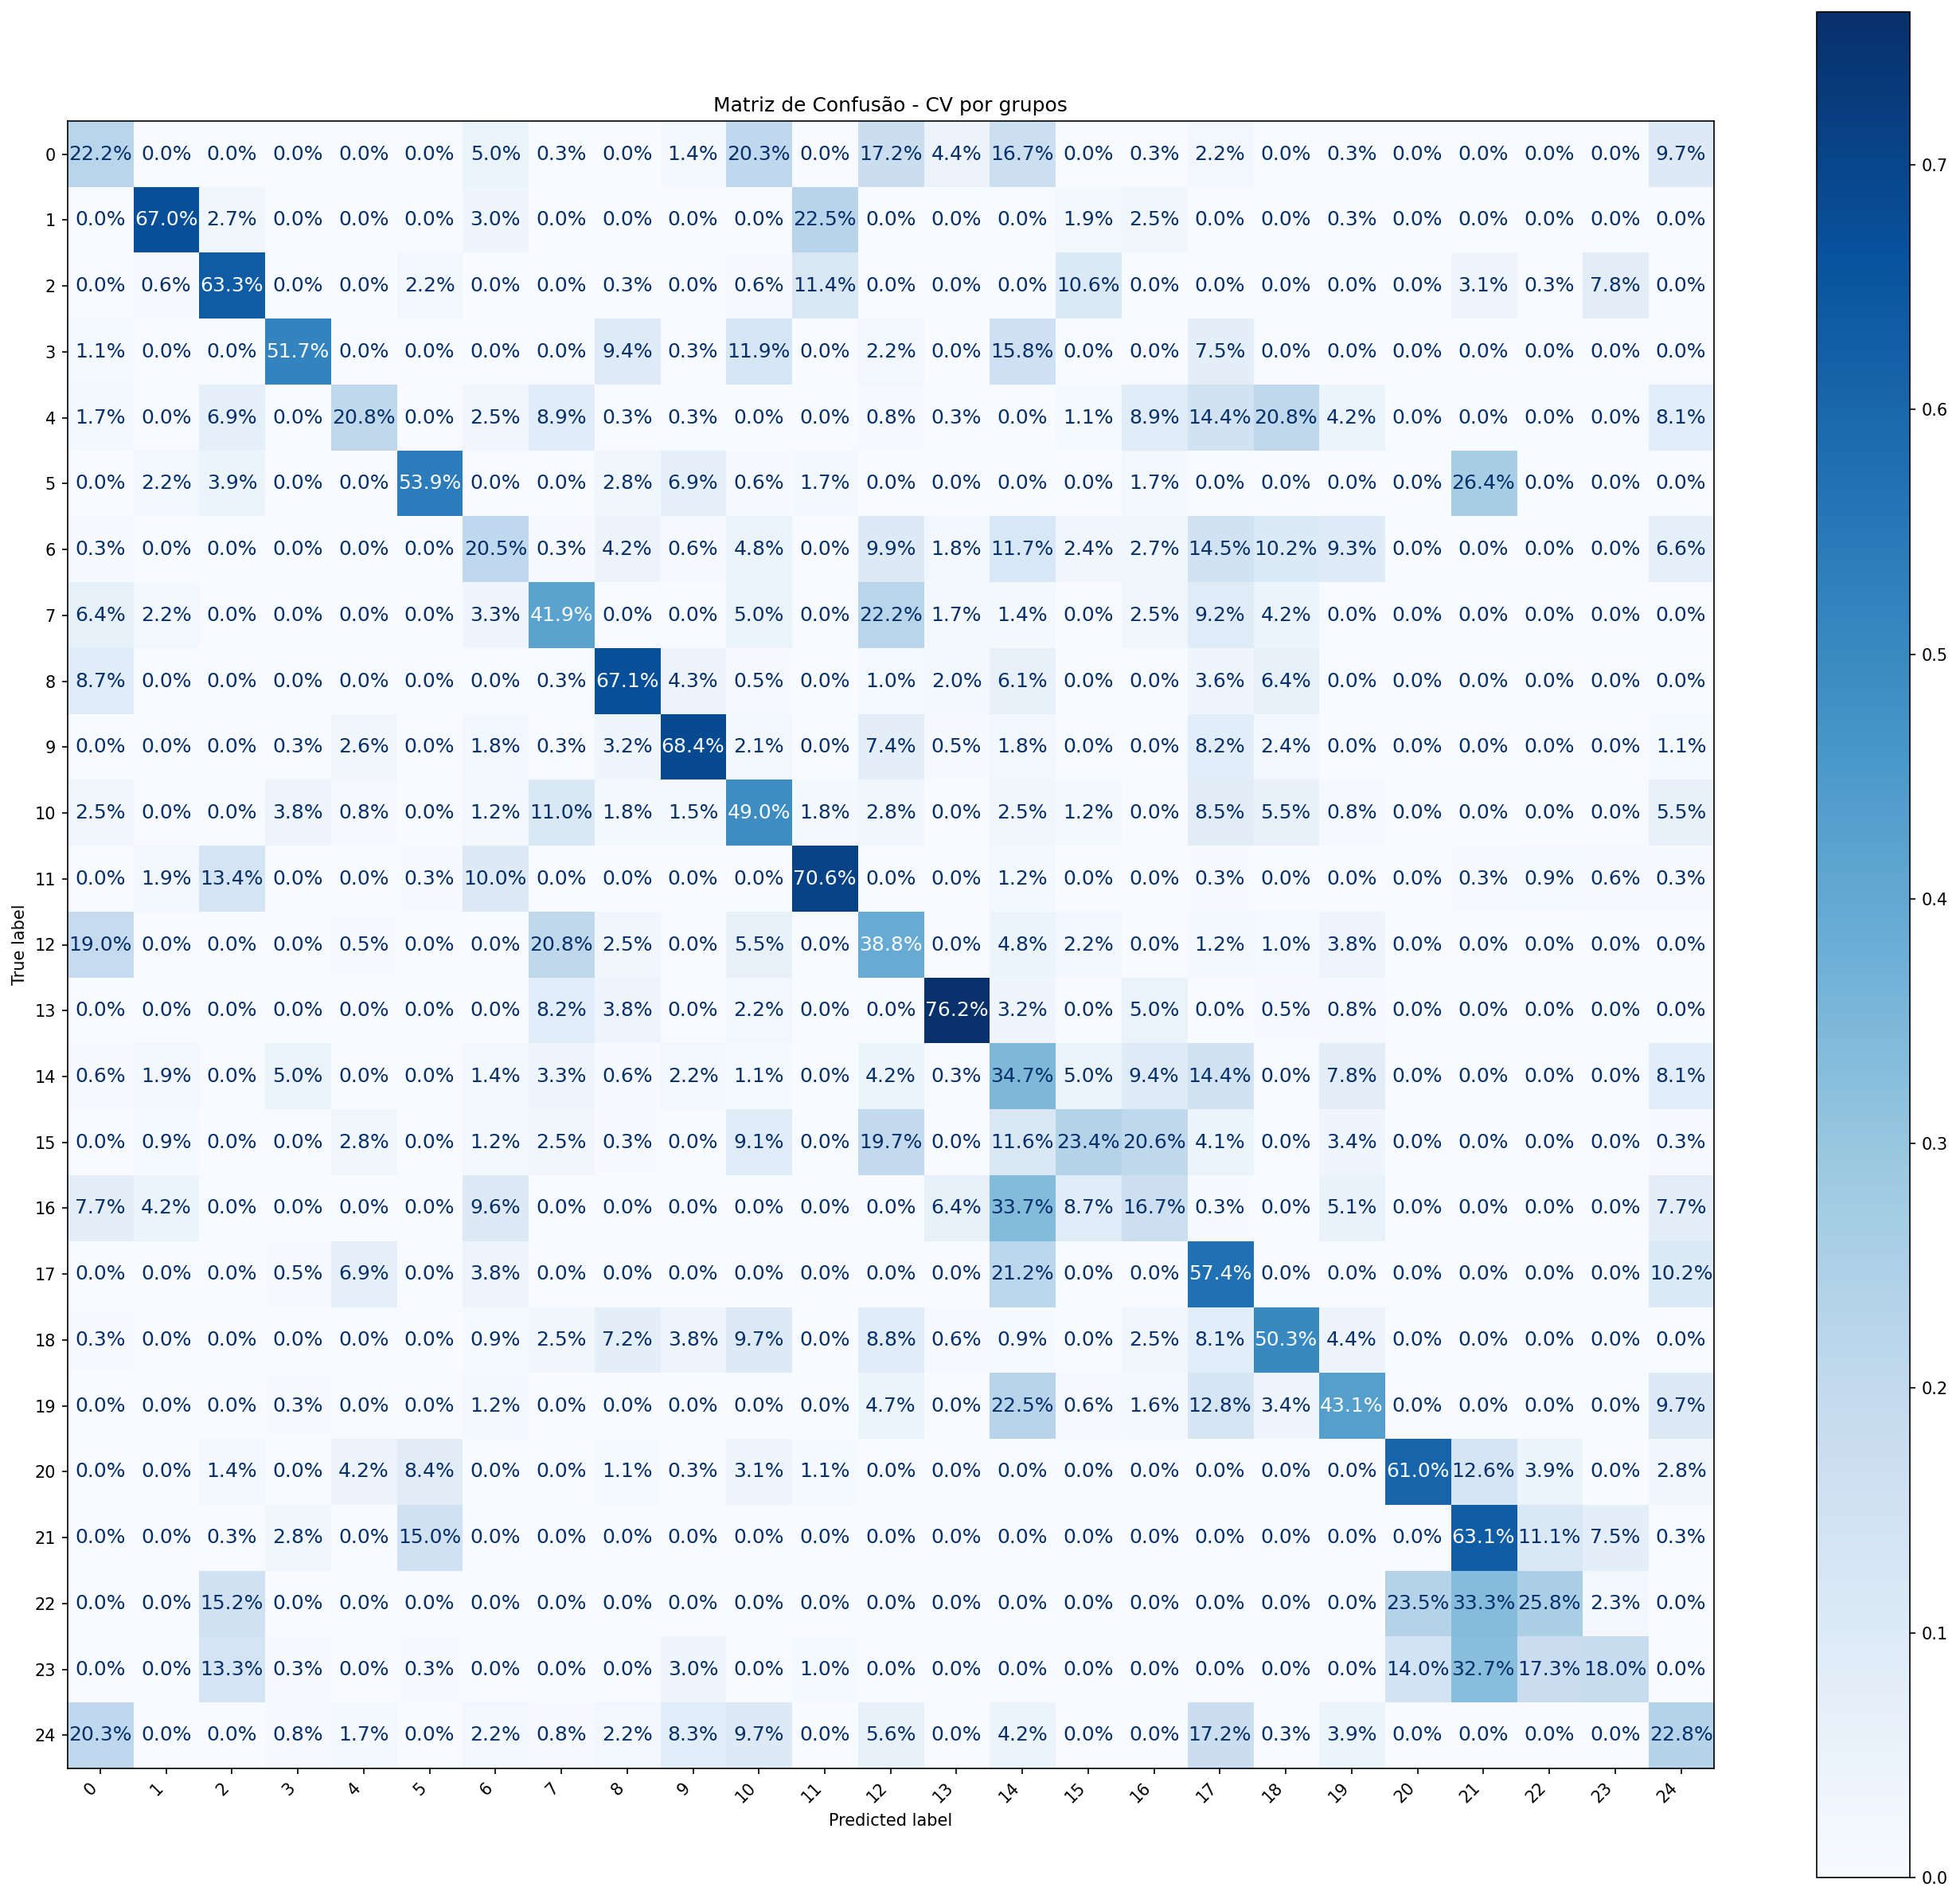

In [22]:
labels = np.unique(y)
y_pred_cv = cross_val_predict(pipeline, X, y, cv=cv, groups=groups, n_jobs=-1)
cm = confusion_matrix(y, y_pred_cv, labels=labels, normalize='true')

fig, ax = plt.subplots(figsize=(18, 16), dpi=150)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', values_format='.1%')  # mostra em %
for t in disp.text_.ravel(): t.set_fontsize(12) 
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Matriz de Confusão - CV por grupos')
fig.tight_layout()
plt.show()

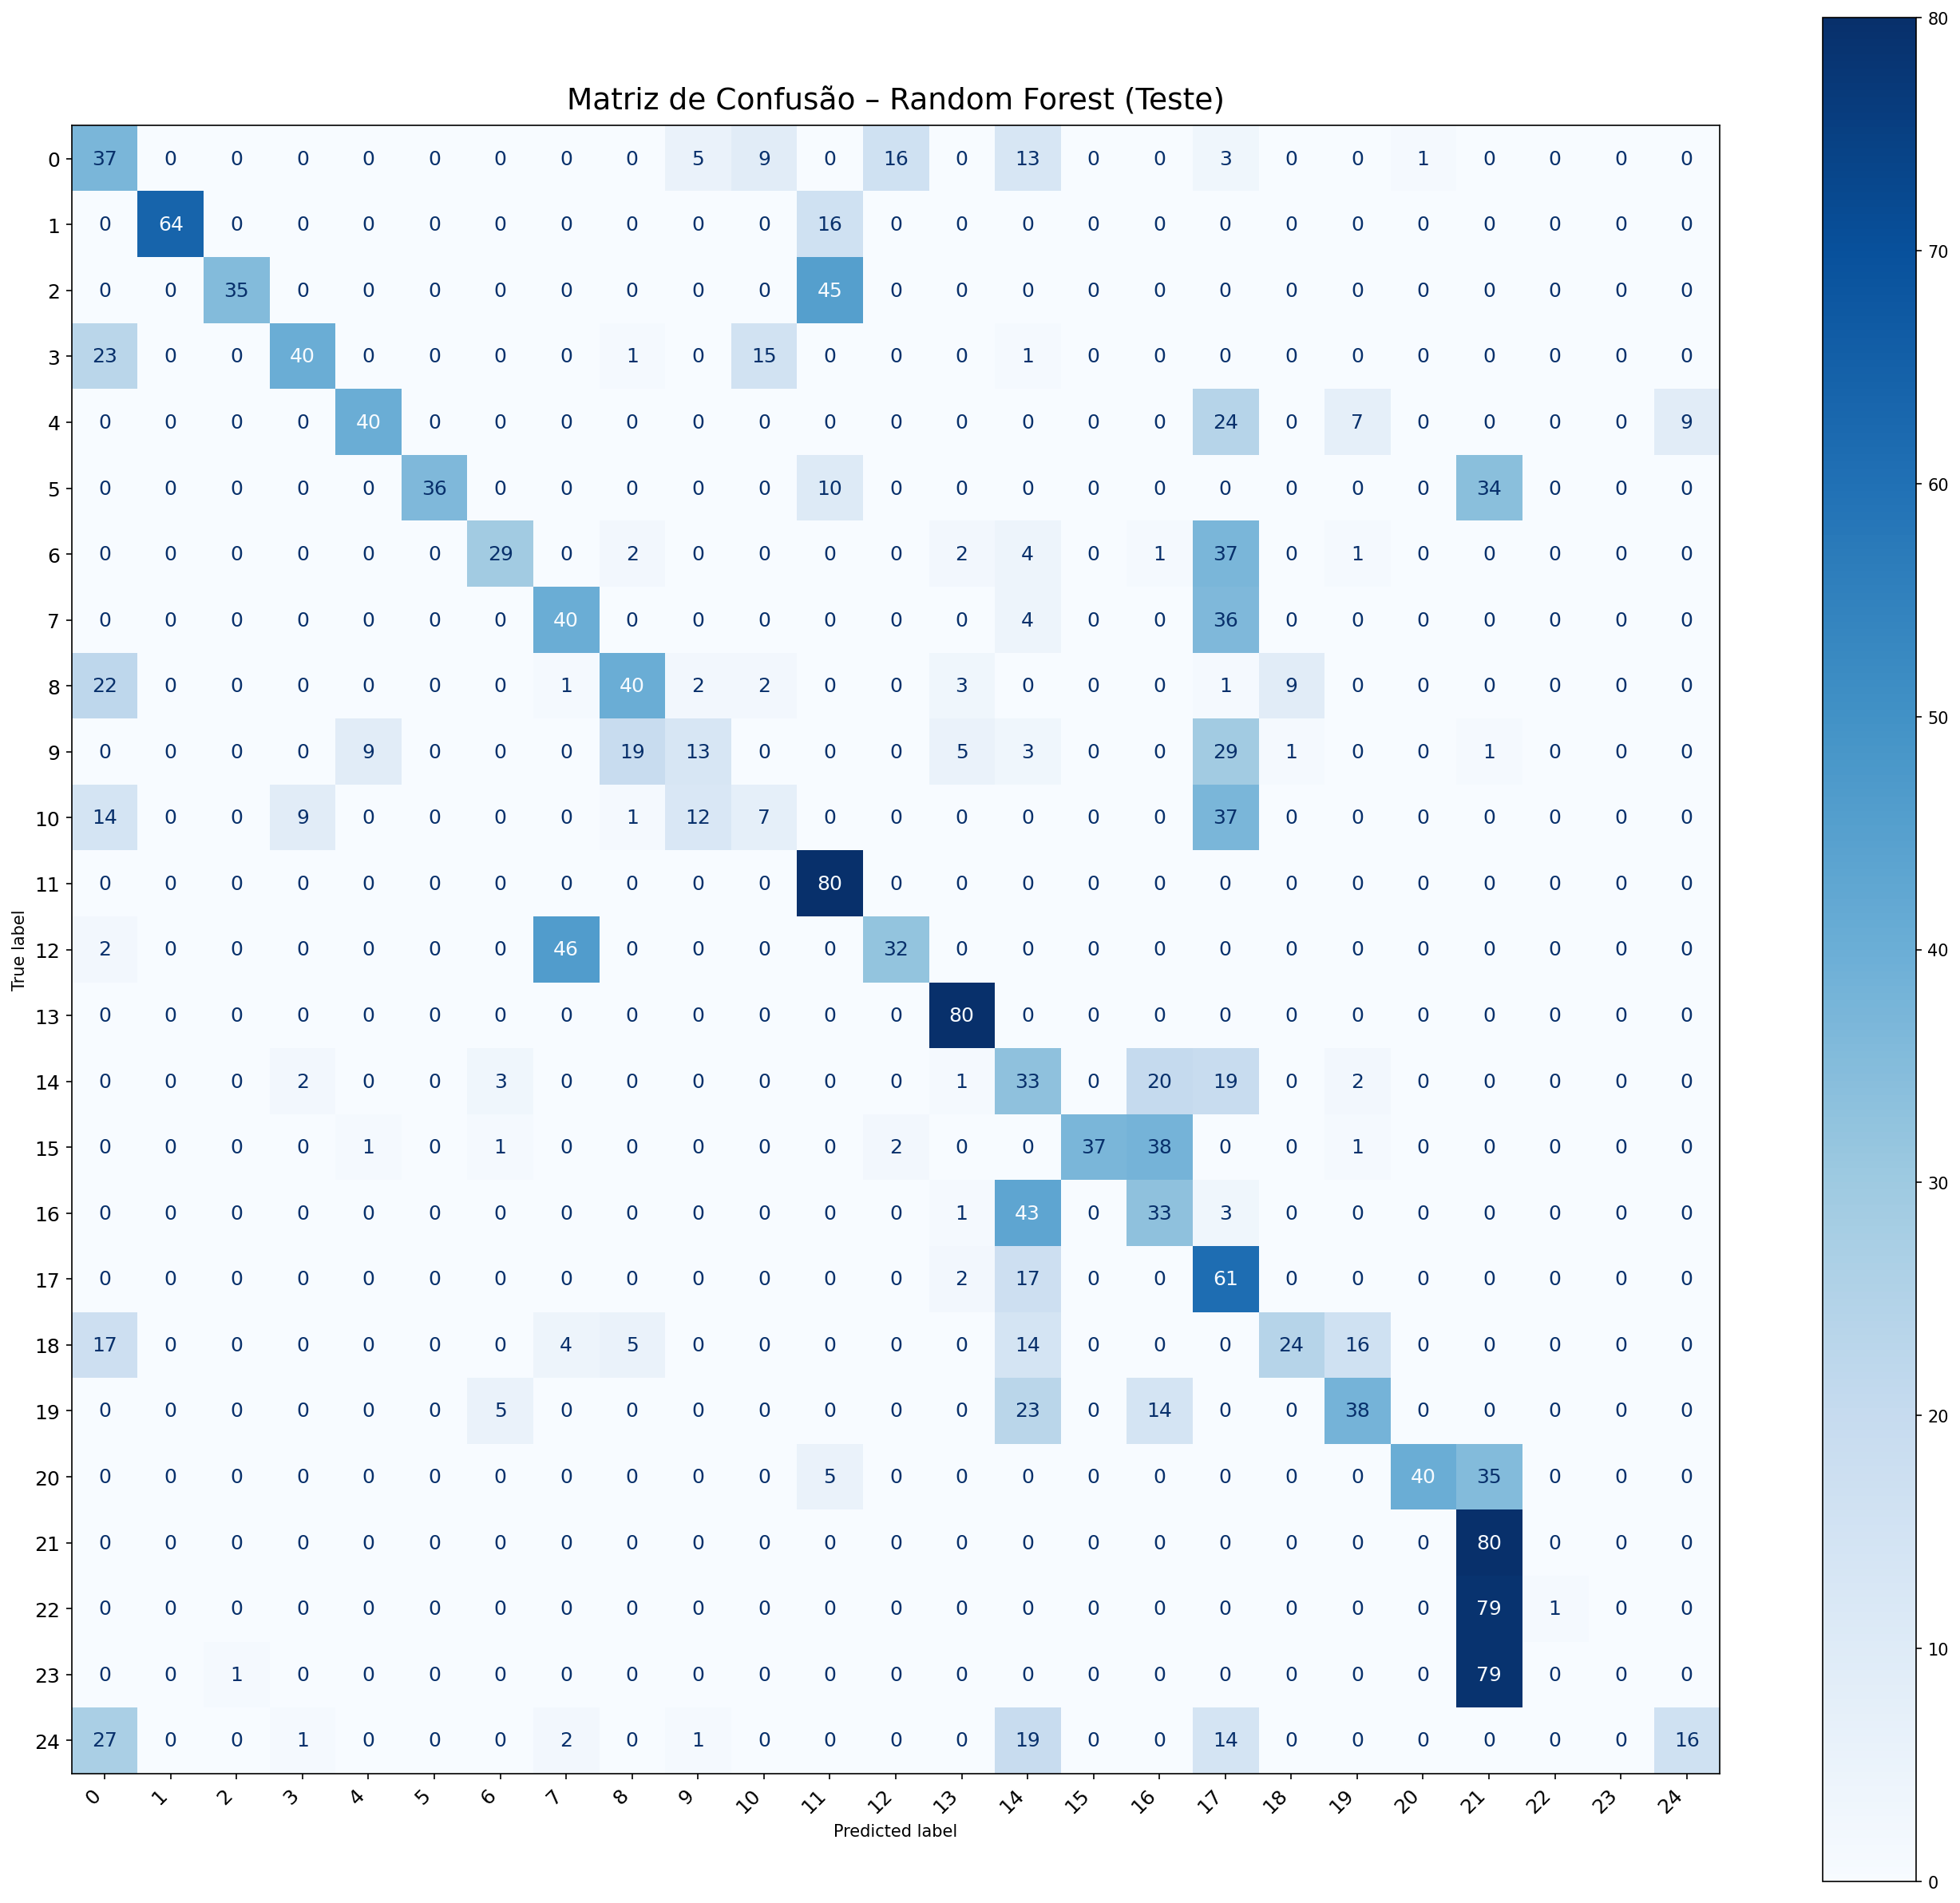

In [23]:

labels = pipeline.classes_
cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(18, 16), dpi=150)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', values_format='d')
for t in disp.text_.ravel(): t.set_fontsize(12)  # evita números se atropelarem
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
ax.set_title('Matriz de Confusão – Random Forest (Teste)', fontsize=18, pad=10)
fig.tight_layout()
plt.show()

## KNN


### Pipeline

In [24]:
# Criando o pipeline com preprocessamento e KNN
knn_pipeline = Pipeline([
    ('preprocess', preprocess),
    ("pca", PCA(n_components=70, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=200, weights='uniform', metric='manhattan', p=1))
])


### Validacao cruzada

In [25]:

# Validação cruzada para F1-Score usando StratifiedGroupKFold para evitar vazamento de dados
# Isso garante que exemplos do mesmo intérprete não apareçam em diferentes folds
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
groups = resultados['interprete'].values
f1_scores = cross_val_score(knn_pipeline, X, y, cv=cv, scoring='f1_macro', groups=groups)
print("\nF1-Score com validação cruzada estratificada por grupos (5-fold):")
print(f"Média: {f1_scores.mean():.4f}, Desvio padrão: {f1_scores.std():.4f}")
print(f"Scores individuais: {f1_scores}")



F1-Score com validação cruzada estratificada por grupos (5-fold):
Média: 0.3114, Desvio padrão: 0.0782
Scores individuais: [0.41511396 0.3153666  0.37670409 0.20833854 0.24131407]


### test set

In [26]:
# Treinando o modelo
knn_pipeline.fit(X_train, y_train)

# Fazendo previsões
y_pred = knn_pipeline.predict(X_test)

# Avaliando o modelo
print("Resultados do KNN:")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='macro'):.4f}")


Resultados do KNN:
Acurácia: 0.3545
F1-Score: 0.3385


### Matriz de Confusao

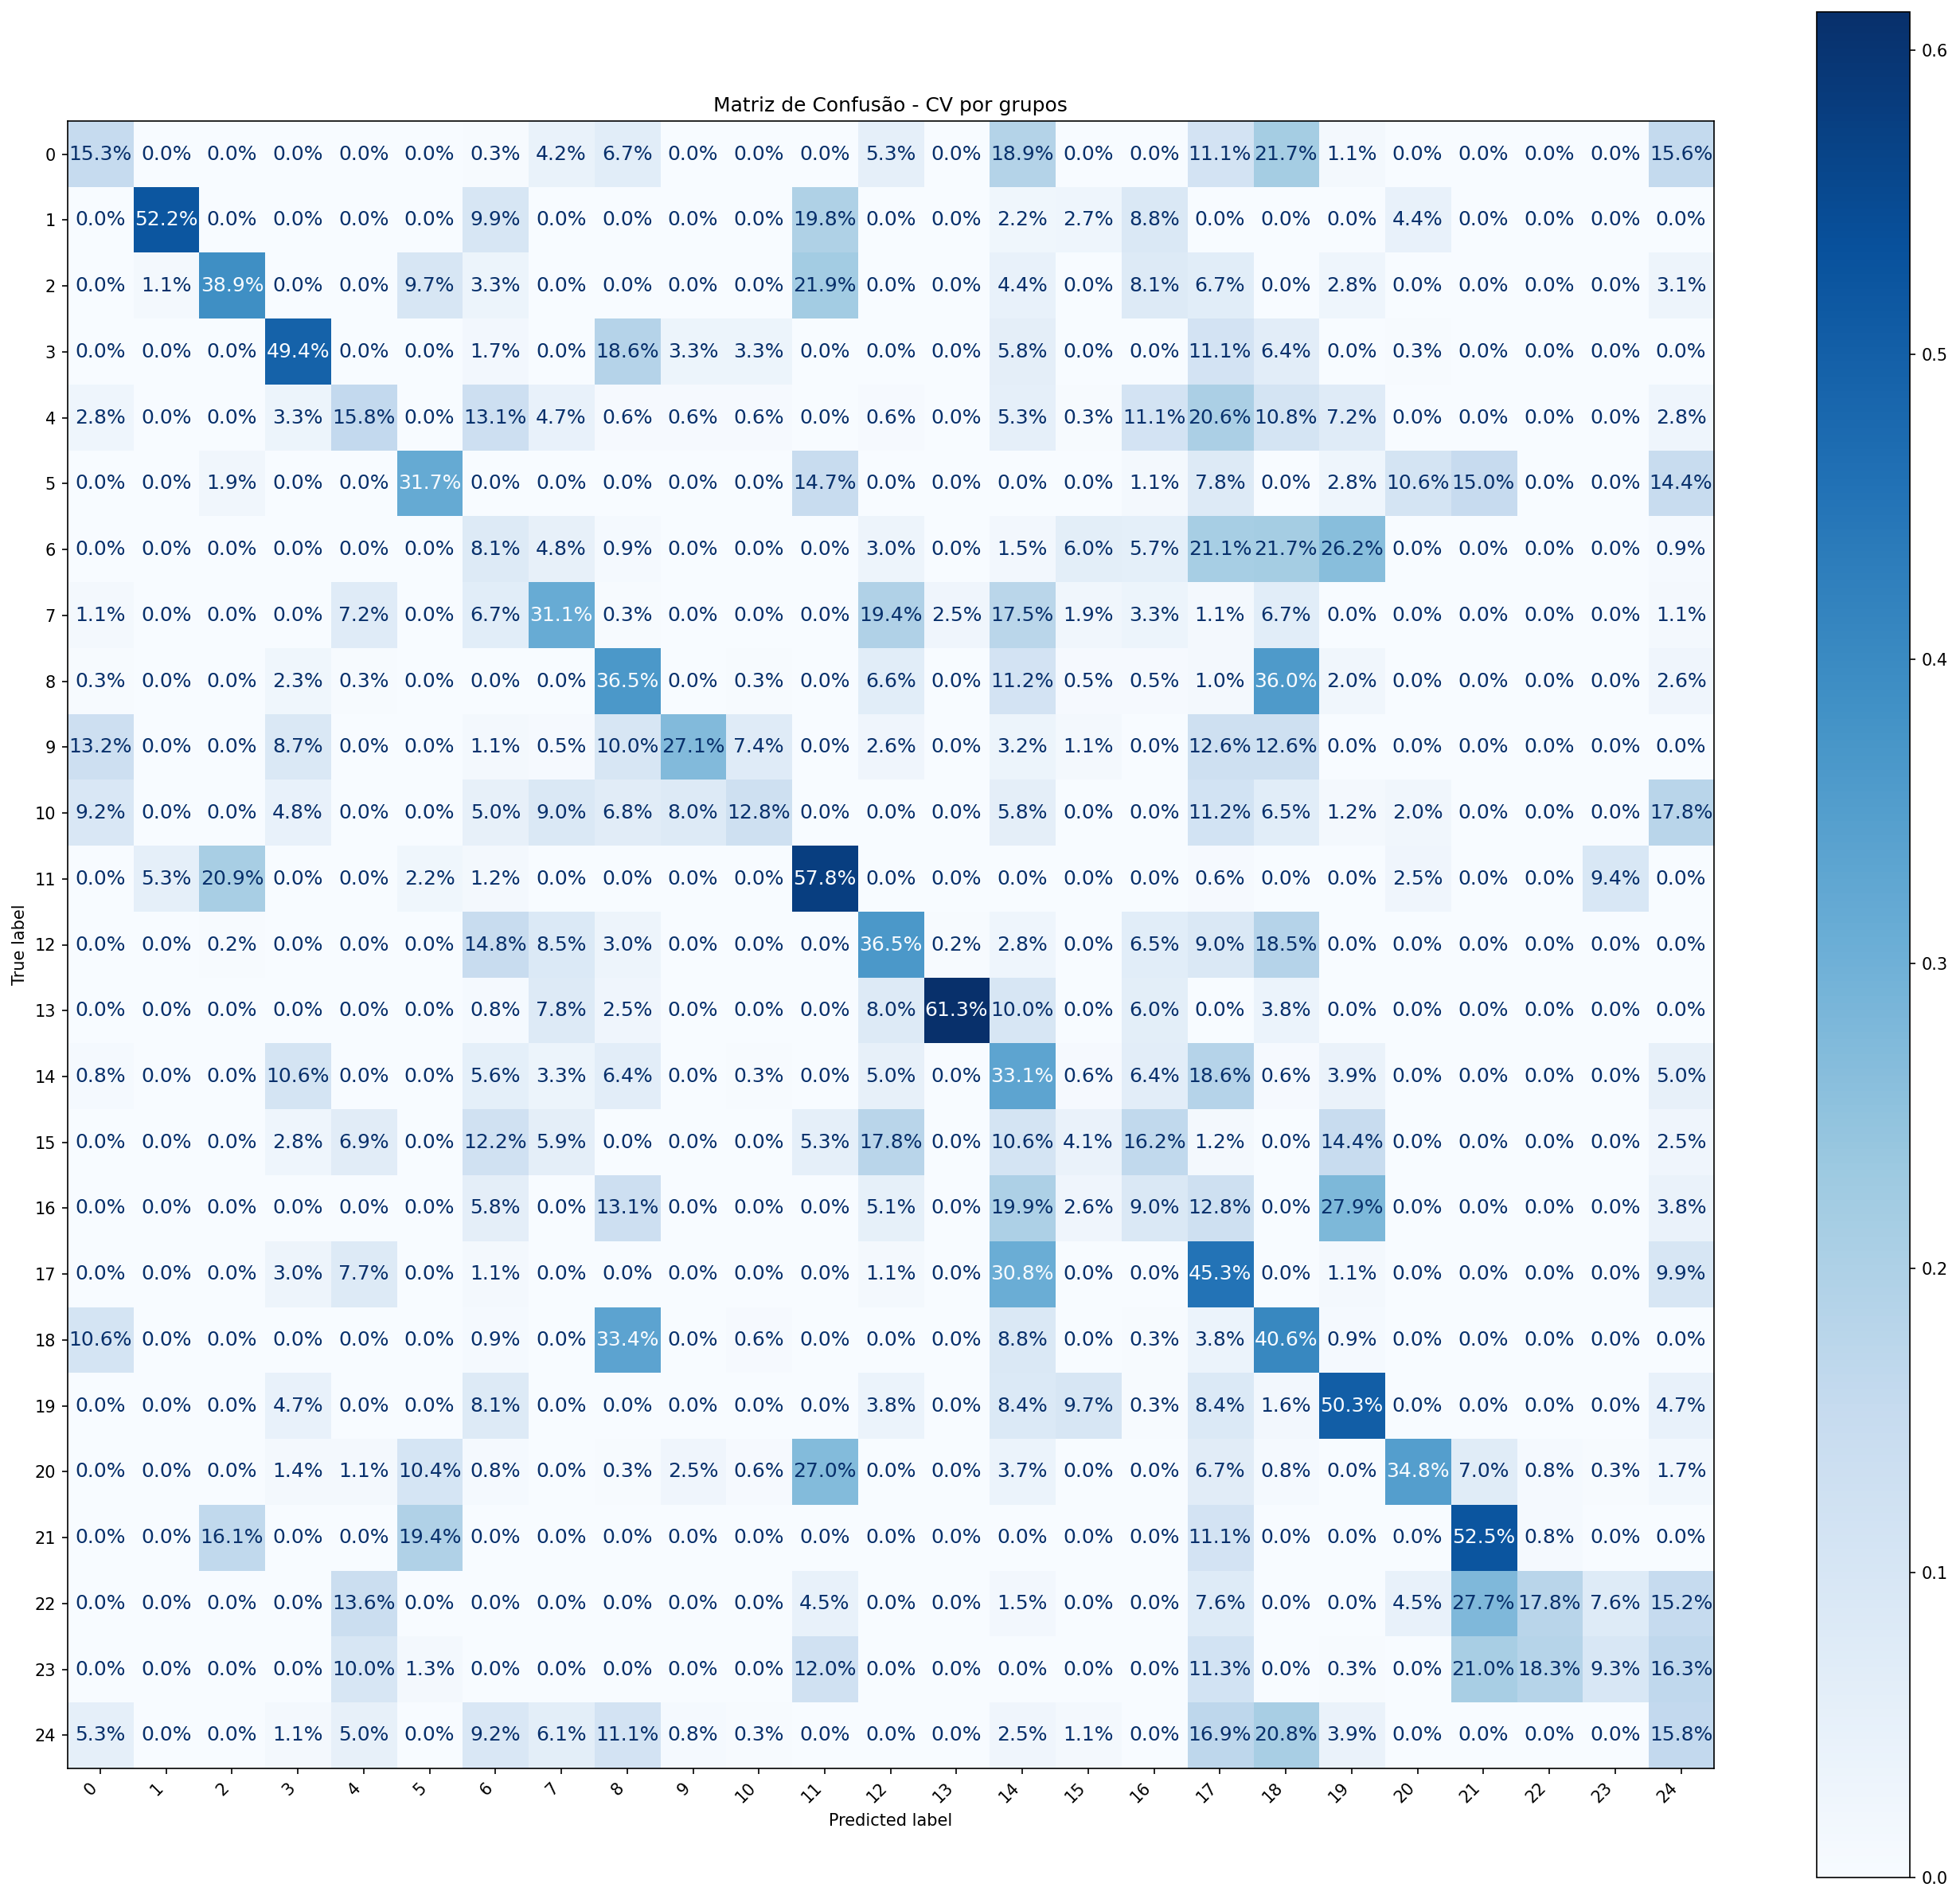

In [27]:
# Matriz de confusão normalizada
labels = np.unique(y)
y_pred_cv = cross_val_predict(knn_pipeline, X, y, cv=cv, groups=groups, n_jobs=-1)
cm = confusion_matrix(y, y_pred_cv, labels=labels, normalize='true')

fig, ax = plt.subplots(figsize=(18, 16), dpi=150)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', values_format='.1%')  # mostra em %
for t in disp.text_.ravel(): t.set_fontsize(12) 
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Matriz de Confusão - CV por grupos')
fig.tight_layout()
plt.show()

# MLP


### Pipeline

In [28]:
# Criando o pipeline para o MLP
mlp_pipeline = Pipeline([
    ('preprocess', preprocess),
    ("pca", PCA(n_components=40, random_state=42)),  # opcional, compare com None
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(100,),  # Tamanho das camadas ocultas
        activation='relu',          # Função de ativação
        solver='adam',              # Otimizador
        alpha=0.0001,               # Termo de regularização
        batch_size='auto',          # Tamanho do lote
        learning_rate='constant',   # Taxa de aprendizado
        learning_rate_init=0.001,   # Taxa de aprendizado inicial
        max_iter=400,               # Número máximo de iterações
        random_state=RANDOM_STATE,  # Semente aleatória
        verbose=False                # Para obter informações de loss durante o treinamento
    ))
])

### Cros validation f1 score

In [29]:
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
groups = resultados['interprete'].values
f1_scores = cross_val_score(mlp_pipeline, X, y, cv=cv, scoring='f1_macro', groups=groups)
print("\nF1-Score com validação cruzada estratificada por grupos (5-fold):")
print(f"Média: {f1_scores.mean():.4f}, Desvio padrão: {f1_scores.std():.4f}")
print(f"Scores individuais: {f1_scores}")



F1-Score com validação cruzada estratificada por grupos (5-fold):
Média: 0.4534, Desvio padrão: 0.1181
Scores individuais: [0.56488689 0.41833704 0.60449553 0.27891003 0.40030316]


### Matriz de confusao

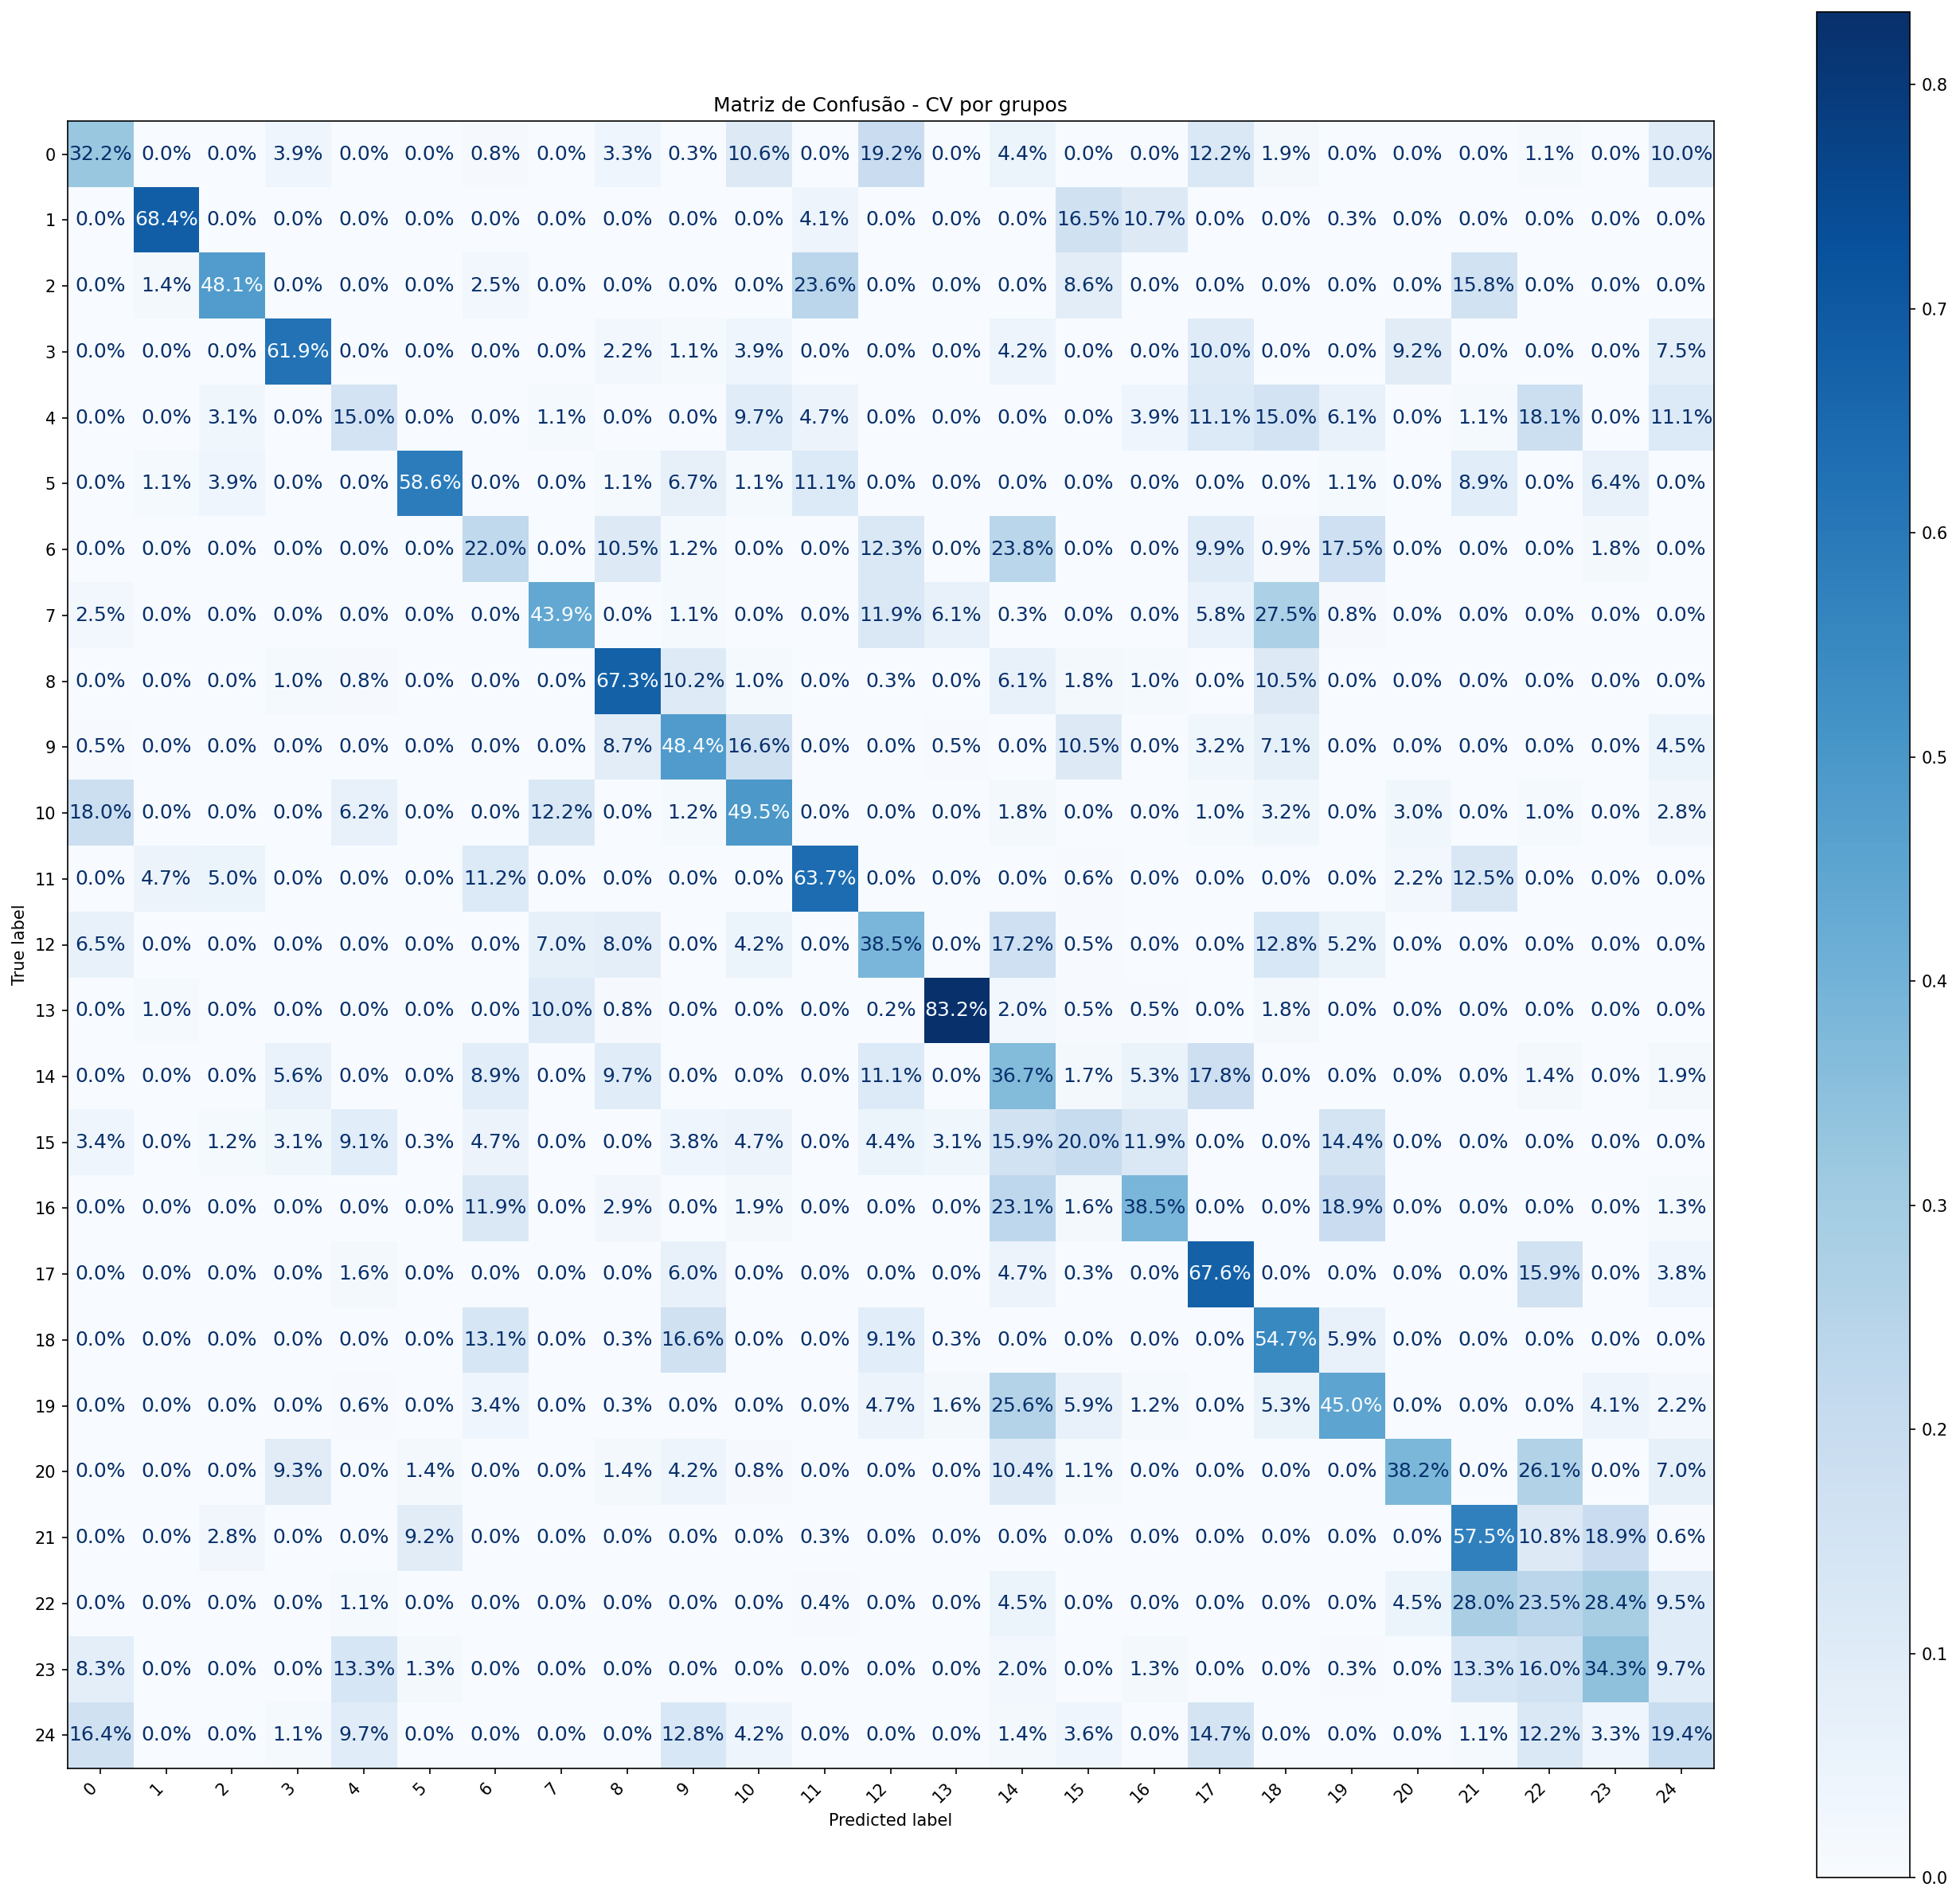

In [30]:
# Matriz de confusão normalizada
labels = np.unique(y)
y_pred_cv = cross_val_predict(mlp_pipeline, X, y, cv=cv, groups=groups, n_jobs=-1)
cm = confusion_matrix(y, y_pred_cv, labels=labels, normalize='true')

fig, ax = plt.subplots(figsize=(18, 16), dpi=150)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', values_format='.1%')  # mostra em %
for t in disp.text_.ravel(): t.set_fontsize(12) 
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Matriz de Confusão - CV por grupos')
fig.tight_layout()
plt.show()

# Teste de implementacao com validation set
- Adicionar Validation set para tirar overfit

In [31]:
# Definindo intérpretes que vão para os conjuntos de teste e validação
test_interpretes = ['Dannubia', 'Cecilia']
val_interpretes = ['Jackeline']  # Separando um intérprete para validação

# Criando máscaras para teste, validação e treino
mask_test = resultados['interprete'].isin(test_interpretes)
mask_val = resultados['interprete'].isin(val_interpretes)

# Separando os conjuntos
X_train = X[~(mask_test | mask_val)].copy()
y_train = y[~(mask_test | mask_val)].copy()

X_val = X[mask_val].copy()
y_val = y[mask_val].copy()

X_test = X[mask_test].copy()
y_test = y[mask_test].copy()

print(f"Conjunto de treino: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Conjunto de validação: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Conjunto de teste: X_test={X_test.shape}, y_test={y_test.shape}")

# Criando preprocessador para features numéricas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),  # Usando RobustScaler para normalização baseada em mediana e IQR
    ],
    remainder='drop'
)


Conjunto de treino: X_train=(5784, 96), y_train=(5784,)
Conjunto de validação: X_val=(1000, 96), y_val=(1000,)
Conjunto de teste: X_test=(2000, 96), y_test=(2000,)


### Fit preprocess + PCA apenas no TREINO

In [32]:
prep_pca = Pipeline([
    ('preprocess', preprocess),                  # seu RobustScaler em numeric_features
    ('pca', PCA(n_components=40, random_state=42))  # ajuste n_components conforme seus testes
])
X_train_tr = prep_pca.fit_transform(X_train)
X_val_tr   = prep_pca.transform(X_val)
X_test_tr  = prep_pca.transform(X_test)

classes = np.unique(y_train)
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),   
    activation='relu',
    solver='adam',
    alpha=1e-3,                     # L2 mais forte 
    learning_rate='constant',
    learning_rate_init=1e-3,
    batch_size=128,
    max_iter=1,                     # 1 época por chamada
    warm_start=True,                # reutiliza pesos entre chamadas
    shuffle=True,
    random_state=RANDOM_STATE,
    verbose=False                  
)

# Loop de treino com early stopping por *validation loss*
max_epochs   = 500
patience     = 20          # nº de épocas sem melhora antes de parar
min_delta    = 1e-4        # melhoria mínima para considerar "melhorou"
best_val     = np.inf
pat_count    = 0
best_model   = None
train_curve, val_curve = [], []

# Desabilitar warnings durante o treinamento
warnings.filterwarnings("ignore", category=UserWarning)

for epoch in range(1, max_epochs + 1):
    # uma "época"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mlp.fit(X_train_tr, y_train)

    # train loss (última loss interna do MLP)
    train_loss = mlp.loss_curve_[-1] if mlp.loss_curve_ else np.nan
    train_curve.append(train_loss)

    # val loss (log_loss com as probabilidades do modelo)
    proba_val = mlp.predict_proba(X_val_tr)
    val_loss = log_loss(y_val, proba_val, labels=classes)
    val_curve.append(val_loss)

    # early stopping por paciência
    if val_loss + min_delta < best_val:
        best_val = val_loss
        pat_count = 0
        best_model = deepcopy(mlp)   # salva melhor conjunto de pesos
    else:
        pat_count += 1
        if pat_count >= patience:
            print(f"Early stopping na época {epoch} (val loss não melhora há {patience} épocas).")
            break

print(f"Melhor val loss: {best_val:.6f}")


Early stopping na época 25 (val loss não melhora há 20 épocas).
Melhor val loss: 0.943475


### Curva de Loss

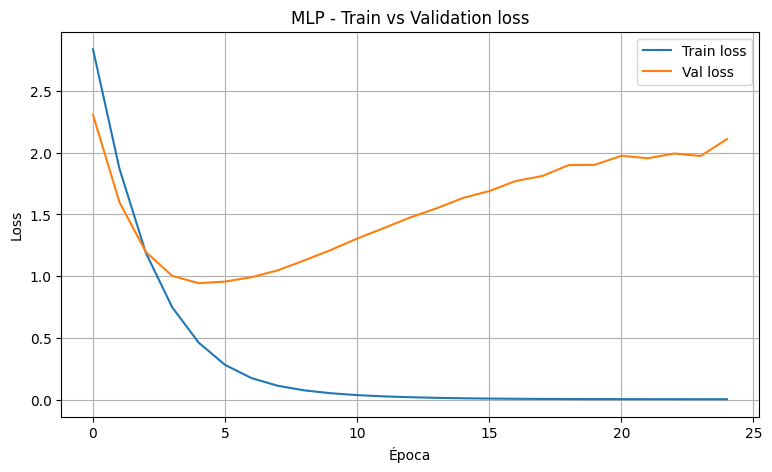

In [33]:

# 4) Plota curvas de perda (train vs validation)
plt.figure(figsize=(9,5))
plt.plot(train_curve, label="Train loss")
plt.plot(val_curve,   label="Val loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("MLP - Train vs Validation loss")
plt.legend()
plt.grid(True)
plt.show()

names = [str(c) for c in label_encoder.classes_]          
labels = np.arange(len(names))                            


### Avaliacao do Validation

In [34]:

y_val_pred = best_model.predict(X_val_tr)
print("\nValidação (intérprete(s) separado(s)):")
print(f"Acurácia: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"F1-macro: {f1_score(y_val, y_val_pred, average='macro'):.4f}")
print(classification_report(y_val, y_val_pred,
                            labels=labels, target_names=names))


Validação (intérprete(s) separado(s)):
Acurácia: 0.6910
F1-macro: 0.6575
                  precision    recall  f1-score   support

          Adição       0.97      0.70      0.81        40
           Aluno       1.00      1.00      1.00        40
    Antropologia       1.00      1.00      1.00        40
       Apontador       1.00      1.00      1.00        40
        Apostila       0.44      1.00      0.62        40
        Biologia       0.65      1.00      0.78        40
Bolsa de Estudos       0.39      0.57      0.46        40
        Capítulo       1.00      1.00      1.00        40
          Classe       1.00      0.97      0.99        40
       Coerência       0.00      0.00      0.00        40
          Coesão       1.00      0.38      0.55        40
          Colega       1.00      1.00      1.00        40
        Conceito       0.43      1.00      0.60        40
        Contexto       1.00      0.95      0.97        40
           Curso       0.00      0.00      0.00        

### Avaliacao do test set

In [35]:
y_test_pred = best_model.predict(X_test_tr)
print("\nTeste (intérpretes fora do treino):")
print(f"Acurácia: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-macro: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(classification_report(y_test, y_test_pred,
                            labels=labels, target_names=names))


Teste (intérpretes fora do treino):
Acurácia: 0.4300
F1-macro: 0.4067
                  precision    recall  f1-score   support

          Adição       0.33      0.48      0.39        84
           Aluno       1.00      0.80      0.89        80
    Antropologia       0.75      0.50      0.60        80
       Apontador       0.86      0.75      0.80        80
        Apostila       1.00      0.04      0.07        80
        Biologia       1.00      0.30      0.46        80
Bolsa de Estudos       0.42      0.24      0.30        76
        Capítulo       0.45      0.35      0.39        80
          Classe       0.70      0.20      0.31        80
       Coerência       0.00      0.00      0.00        80
          Coesão       0.10      0.14      0.11        80
          Colega       0.48      1.00      0.65        80
        Conceito       0.58      0.47      0.52        80
        Contexto       0.96      1.00      0.98        80
           Curso       0.03      0.05      0.04        80


### Matriz de Confusao

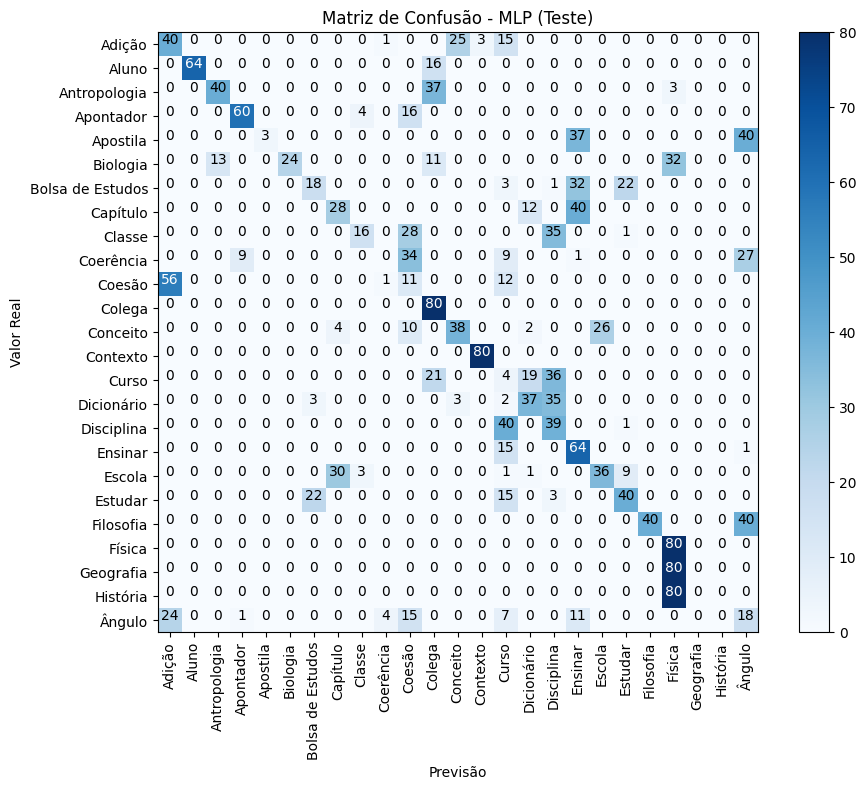

In [36]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - MLP (Teste)')
plt.colorbar()
ticks = np.arange(len(label_encoder.classes_))
plt.xticks(ticks, label_encoder.classes_, rotation=90)
plt.yticks(ticks, label_encoder.classes_)
plt.xlabel('Previsão'); plt.ylabel('Valor Real')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()
